<a href="https://colab.research.google.com/github/marquinhosmar/DataScience---MVP-Machine-Learning-Analytics/blob/main/Projeto_MVP_ML_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Machine Learning & Analytics

**Nome:** Marcos Correia Araujo

**Matrícula:** 4052025000145

**Dataset:** [Siconfi](https://apidatalake.tesouro.gov.br/ords/siconfi/tt/dca)

**---OBSERVAÇÕES IMPORTANTES---**
O dataset do SICONFI (Sistema de Informações Contábeis e Fiscais do Setor Público Brasileiro) é uma plataforma do Tesouro Nacional que recebe, processa e divulga informações contábeis, financeiras e estatísticas de todos os entes federativos. É uma ferramenta essencial para a transparência e o acompanhamento da gestão fiscal do país.


##Descrição do Problema

O conjunto de dados do Siconfi é um conjunto de dados multivariado que consiste em medidas que permitem analisar várias situações financeiras dos estados e municipios brasieliros, tais como: evolução da **`Receita`** e **`Despesa Pública`**, capacidade de **`Investimento`**, situação da responsabilidade fiscal, depência de transferências de outros entes, comparativos entre regiões, qualidade do gasto público, entre outros.

O `investimento público` é universalmente reconhecido como um pilar para o desenvolvimento econômico e social. Por meio da formação de capital em infraestrutura, educação, saúde, e outras areas de interesse público, ele não apenas estimula a atividade econômica no curto prazo, mas também eleva a produtividade e a competitividade no longo prazo, sendo um instrumento essencial para a redução das desigualdades.

Em um país de dimensões continentais e com profundas disparidades regionais como o Brasil, a alocação de investimentos pelos governos municipais assume um papel ainda mais crítico, sendo fundamental para promover a convergência de renda e garantir o acesso equitativo a serviços públicos de qualidade.

O presente trabalho tem como objetivos principais analisar os investimentos públicos dos entes municipais do Estado do Ceará durante o período de 2019 a 2024. Bem como a relação `investimento` sobre a `despesa total`, e o `investimento per capta` por habitante.

Inicialmente o objetivo inicial era analisar todos os municípios do Brasil no intervalo citado anteriormente. Devido a grande quantidade de informações e a demora para baixar os dados, optou-se por restringir aos munípios do Estado do Ceará que é o local onde o autor deste trabalho reside.

O **`investimento público`** é uma **`despesa de capital`**. Incluí obras públicas (escolas, hospitais, estradas), compra de equipamentos e imóveis permanentes. Seu objetivo é o desenvolvimento econômico e social (infraestrutura, serviços, geração de ativos).

## Hipóteses do Problema

Restrigindo a amostra aos municipíos do estado do Ceará, as hipóteses que tracei são as seguintes:

- O **`Investimento Público`** segue um padrão uniforme durante um determinado período de tempo ou apresenta variações?

- Avaliar se a maior **`Receita Total`** ou maior **`Despesa Total`** está associada a maior capacidade de **`Investimento`** per capta.

-  Municípios com maiores gastos brutos são os que mais realizam investimentos em termos percentuais?

- É possível `classificar` a `saúde financeira` de um município com base em `indicadores demográficos` e `indicadores financeiros` relacionados ao `Investimento Público`?



## Tipo de Problema


Este é um problema de **`Classificação Supervisionada`**. Dado um conjunto de características como `Despesa Total`, `Depesa Corrente`, `Receita Total`, `Investimento`, `População`, etc, o objetivo é classificar se um município está em com dificuldades orçamentárias com base em seus indicadores de investimento público. Bem como a partir desses mesmos indicadores descobrir  indícios de Saúde Fiscal.

## Seleção de Dados

O dataset do **`siconfi`** é um conjunto de dados de domínio público, amplamente disponível e frequentemente incluído em bibliotecas de aprendizado de máquina. É  utilizado para diversas finalidades de pesquisas econômicas, bem como no meio acadêmico. É necessária uma etapa de seleção de dados externa, pois o dataset  possui muitos dados e de acordo com a finalidade é importante definir o que será filtrado.

O dataset poderia ser carregado diretamente da **`API`** do **`Tesouro Nacional`**, porém para acelerar o processo de importação de dados e garantir que o dataset possa ser importado diretamente do github através de um arquivo csv foi feito os seguintes passos até obter um dataset pronto para importação:

**1**. Inicialmente foi rodado esse código abaixo em outro notebook do colab definindo a coleta:
```
import pandas as pd
import requests

# --- Passo 1: Obter a lista de Municípios do IBGE ---
url_municipios = "https://servicodados.ibge.gov.br/api/v1/localidades/municipios"

try:
    print("Buscando lista de municípios do IBGE...")
    response_ibge = requests.get(url_municipios)
    response_ibge.raise_for_status()

    dados_ibge = response_ibge.json()

    municipios_df = pd.DataFrame(dados_ibge)
    municipios_df['id_ente'] = municipios_df['id'].astype(str)
    municipios_df = municipios_df[['id_ente', 'nome', 'microrregiao']]

    municipios_df['sigla_uf'] = municipios_df['microrregiao'].apply(
        lambda x: x['mesorregiao']['UF']['sigla'] if x is not None else None
    )
    municipios_df = municipios_df.drop(columns=['microrregiao'])

    # Remove as linhas onde a sigla da UF é nula
    municipios_df = municipios_df.dropna(subset=['sigla_uf'])

    print(f"Lista de {len(municipios_df)} municípios obtida com sucesso.")

except requests.exceptions.RequestException as e:
    print(f"Erro ao buscar a lista de municípios do IBGE: {e}")
    municipios_df = pd.DataFrame()
    
# --- Passo 2: Filtrar apenas os municípios do Ceará (CE) ---
municipios_ce = municipios_df[municipios_df['sigla_uf'] == 'CE']
print(f"Filtrando: {len(municipios_ce)} municípios do Ceará (CE) encontrados.")

```









**O que o código acima executa:**

*   Importa as biliotecas *pandas* e *requests*  
*   Obtém a lista de municípios através da api do IBGE;
*   Filtra dentro da lista apenas os munípios do Estado do Ceará;



```
#Iterar sobre os municípios e buscar dados na API do SICONFI ---#

exercicio = range(2019, 2024)  # Intervalo de 5 anos: 2019, 2020, 2021, 2022, 2023
resultados_lista = []

if not municipios_ce.empty:
    for index, row in municipios_ce.iterrows():
        municipio_codigo = row['id_ente']
        municipio_nome = row['nome']

        for ano in exercicio:
            url_base = "https://apidatalake.tesouro.gov.br/ords/siconfi/tt/dca"
            params = {'an_exercicio': ano, 'id_ente': municipio_codigo}

            try:
                response = requests.get(url_base, params=params)
                status = response.status_code
                print(f"Status: {status} para {municipio_nome} ({municipio_codigo}) no ano {ano}")

                if status == 200:
                    dados = response.json()
                    items_list = dados.get('items', [])

                    if not items_list:
                        print(f"  -> Aviso: Nenhum item retornado para {municipio_nome} em {ano}.")
                        continue

                    items = pd.DataFrame(items_list)

                    items['Município'] = municipio_nome
                    items['Codigo_Municipio'] = municipio_codigo
                    items['Ano'] = ano

                    items['valor'] = pd.to_numeric(items['valor'], errors='coerce')

                    resultados_lista.append(items)

                else:
                    print(f"  -> Erro na requisição para {municipio_nome} ({municipio_codigo}) em {ano}. Status: {status}")
                    continue

            except requests.exceptions.RequestException as e:
                print(f"  -> Erro de conexão para {municipio_nome} em {ano}: {e}")
                continue

```


**O que o código acima executa:**


*   Itera sobre os municípios e busca os dados na API do SICONFI;
*   Estabelece o intervalo de 5 anos (de 2019 a 2013);



```

Passo 4: Juntar os resultados ---
if resultados_lista:
    resultados_brutos = pd.concat(resultados_lista, ignore_index=True)
    print("\nDados consolidados em um DataFrame final.")
    print(resultados_brutos.head())
else:
    print("\nNenhum dado foi coletado. O DataFrame final está vazio.")
    resultados_brutos = pd.DataFrame

```

O que o código acima executa:



*   Junta os resultados em um dataframe final;
*   nome do dataframe = DataFrame



```

# --- Passo 5: Exportar o DataFrame para um arquivo CSV ---
if not resultados_brutos.empty:
    nome_arquivo = "dados_siconfi_ceara_2019-2023.csv"
    resultados_brutos.to_csv(nome_arquivo, index=False, encoding='utf-8-sig')
    print(f"\nDados exportados com sucesso para o arquivo: {nome_arquivo}")
else:
    print("\nNenhum dado para exportar. O DataFrame está vazio.")

```

O que o código acima executa:

*   Gera um arquivo *.csv* chamado "dados_siconfi_ceara_2019-2023.csv";
*   É feito o dowload do arquivo para posterior upload no *`github`*;
*   O tempo de execução baixando o dataframe diretamente da API do tesouro demora aproximadamente 10 minutos, com este procedimento o tempo de execução fica menor que 10 segundos;






O referido DataFrame é carregado para o github, de onde estar pronto para ser importado e iniciar o processo de análise:

```
url = "https://media.githubusercontent.com/media/marquinhosmar/datascience-mvp/refs/heads/master/dados_siconfi_ceara_2019-2023.csv"

```

# Importação das Bibliotecas Necessárias e Carga de Dados

Esta seção consolida todas as importações de bibliotecas necessárias para a análise, visualização e pré-processamento dos dados, bem como o carregamento inicial do dataset `dados_siconfi_ceara_2019-2023.csv` que estar alocado no github.

In [97]:
# Setup básico e reprodutibilidade
# Importação das bibliotecas

import os, random, time, sys, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score



SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


In [98]:
# Instalação de pacotes extras
!pip install ipeadatapy
import ipeadatapy as ip
import ipeadatapy

In [99]:
# Importação do dataset e guarda em um dataframe chamado df

url = "https://media.githubusercontent.com/media/marquinhosmar/datascience-mvp/refs/heads/master/dados_siconfi_ceara_2019-2023.csv"
df = pd.read_csv(url)



In [100]:
# Confirmando que o objeto df é um DataFrame do Pandas:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


# Análise de Dados

Nesta etapa de Análise de Dados Exploratória (EDA) sobre o dataset do Siconfi, visamos entender a distribuição, as relações e as características das variáveis, o que é crucial para as etapas subsequentes de pré-processamento e modelagem.

## Total e Tipo das Instâncias

O dataset `df` possui 942.530 instâncias (observações), e 14 colunas. As características de medição são do tipo`float64` (ou ponto flutuante de 64 bits) é um tipo numérico usado para representar números decimais (com casas após a vírgula). Temos também o `int64` (ou inteiro de 64 bits) que é um tipo numérico usado para representar números inteiros (sem casas decimais). E por fim o tipo `object` que é um tipo de dados mais genérico, geralmente ele é usado para armazenar texto (strings).
Não existe valores nulos e nem dados faltantes.

In [101]:
# Total de instâncias
# Tipos de dados por coluna
print(f"Total de instâncias: {len(df)}")
print("\nTipos de dados por coluna:")
print(df.info())

Total de instâncias: 942530

Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942530 entries, 0 to 942529
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   exercicio         942530 non-null  int64  
 1   instituicao       942530 non-null  object 
 2   cod_ibge          942530 non-null  int64  
 3   uf                942530 non-null  object 
 4   anexo             942530 non-null  object 
 5   rotulo            942530 non-null  object 
 6   coluna            942530 non-null  object 
 7   cod_conta         942530 non-null  object 
 8   conta             942530 non-null  object 
 9   valor             942530 non-null  float64
 10  populacao         942530 non-null  int64  
 11  Município         942530 non-null  object 
 12  Codigo_Municipio  942530 non-null  int64  
 13  Ano               942530 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 100.7+ MB
N

In [102]:
# Primeiras 5 linhas
df.head()

,exercicio,instituicao,cod_ibge,uf,anexo,rotulo,coluna,cod_conta,conta,valor,populacao,Município,Codigo_Municipio,Ano
0,2019,Prefeitura Municipal de Abaiara - CE,2300101,CE,DCA-Anexo I-AB,Padrão,31/12/2019,P1.0.0.0.0.00.00,1.0.0.0.0.00.00 - Ativo,"29,758,252.47",11663,Abaiara,2300101,2019
1,2019,Prefeitura Municipal de Abaiara - CE,2300101,CE,DCA-Anexo I-AB,Padrão,31/12/2019,P1.1.0.0.0.00.00,1.1.0.0.0.00.00 - Ativo Circulante,"4,098,827.82",11663,Abaiara,2300101,2019
2,2019,Prefeitura Municipal de Abaiara - CE,2300101,CE,DCA-Anexo I-AB,Padrão,31/12/2019,P1.1.1.0.0.00.00,1.1.1.0.0.00.00 - Caixa e Equivalentes de Caixa,"2,782,629.25",11663,Abaiara,2300101,2019
3,2019,Prefeitura Municipal de Abaiara - CE,2300101,CE,DCA-Anexo I-AB,Padrão,31/12/2019,P1.1.1.1.0.00.00,1.1.1.1.0.00.00 - Caixa e Equivalentes de Caix...,"2,782,629.25",11663,Abaiara,2300101,2019
4,2019,Prefeitura Municipal de Abaiara - CE,2300101,CE,DCA-Anexo I-AB,Padrão,31/12/2019,P1.1.1.1.1.00.00,1.1.1.1.1.00.00 - Caixa e Equivalentes de Caix...,"2,782,629.25",11663,Abaiara,2300101,2019


In [103]:
# Últimas 5 linhas
print(df.tail())

        exercicio                                   instituicao  cod_ibge  uf  \
942525       2023  Prefeitura Municipal de Viçosa do Ceará - CE   2314102  CE   
942526       2023  Prefeitura Municipal de Viçosa do Ceará - CE   2314102  CE   
942527       2023  Prefeitura Municipal de Viçosa do Ceará - CE   2314102  CE   
942528       2023  Prefeitura Municipal de Viçosa do Ceará - CE   2314102  CE   
942529       2023  Prefeitura Municipal de Viçosa do Ceará - CE   2314102  CE   

                 anexo  rotulo      coluna                      cod_conta  \
942525  DCA-Anexo I-HI  Padrão  31/12/2023               P4.9.9.6.0.00.00   
942526  DCA-Anexo I-HI  Padrão  31/12/2023               P4.9.9.6.1.00.00   
942527  DCA-Anexo I-HI  Padrão  31/12/2023               P4.9.9.9.0.00.00   
942528  DCA-Anexo I-HI  Padrão  31/12/2023               P4.9.9.9.1.00.00   
942529  DCA-Anexo I-HI  Padrão  31/12/2023  ResultadoPatrimonialDoPeriodo   

                                                  

In [104]:
# Verificando a quantidade de valores nulos por coluna
print("Valores nulos por coluna:")
print(df.isnull().sum())

Valores nulos por coluna:
exercicio           0
instituicao         0
cod_ibge            0
uf                  0
anexo               0
rotulo              0
coluna              0
cod_conta           0
conta               0
valor               0
populacao           0
Município           0
Codigo_Municipio    0
Ano                 0
dtype: int64


In [105]:
# Quantas linhas têm ao menos um valor vazio
df.isnull().any(axis=1).sum()

np.int64(0)

## Atributos do Dataset

O dataset `df` contém 942.530 instâncias com 14 colunas:

- ***exercicio*** : o ano em que os fatos contábeis ocorreram e foram registrados.
- ***instituicao*** : descrição do nome do Município.
- ***cod_ibge*** : código do estado segundo a classificação do IBGE.
- ***uf*** : sigla do estado de localização dos Municípios.
- ***anexo*** :  indica em qual anexo dos demonstrativos contábeis ou fiscais aquela conta aparece ou deve ser demonstrada, conforme exigências da contabilidade pública brasileira.
- ***rotulo*** : é o nome oficial e padronizado da conta contábil, definido pela autoridade competente (como o Tesouro Nacional no caso do PCASP).
- ***coluna*** : dia, mês e ano (coincide com o exercício).
- ***cod_conta*** : número da conta do plano de contas.
- ***conta*** : nome da conta.
- ***valor*** : representa o montante financeiro associado àquela conta contábil.
- ***populacao*** : população do município.
- ***Município*** : repete novamente o município do estado.
- ***Código_Municipio*** : código IBGE do município.
- ***Ano*** : coincide com o ano de exercício.

#Tratamento dos dados

Baseado no foco do problema a ser analisado e nas hipóteses que precisam ser respondidas, será feito alguns comandos e ajustes para enxugar e tratar os dados disponíveis no DataFrame `df`:

In [106]:
# Garante que a coluna 'valor' seja numérica
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')

# Remove linhas sem valor numérico
df = df.dropna(subset=['valor'])

# Função para aplicar os padrões de contas por ano
def get_padroes_conta(ano):
    if ano <= 2017:
        return {
            'corrente': "3.0.00.00.00.00 - Despesas Correntes",
            'capital': "4.0.00.00.00.00 - Despesas de Capital",
            'rc': "1.0.0.0.00.00.00 - Receitas Correntes",
            'rk': "2.0.0.0.00.00.00 - Receitas de Capital",
            'rc_intra': "7.0.0.0.00.00.00 - Receitas Correntes",
            'rk_intra': "8.0.0.0.00.00.00 - Receitas de Capital",
            'investimento': "4.4.00.00.00.00 - Investimentos"
        }
    else:
        return {
            'corrente': "3.0.00.00.00 - Despesas Correntes",
            'capital': "4.0.00.00.00 - Despesas de Capital",
            'rc': "1.0.0.0.00.0.0 - Receitas Correntes",
            'rk': "2.0.0.0.00.0.0 - Receitas de Capital",
            'rc_intra': "7.0.0.0.00.0.0 - Receitas Correntes",
            'rk_intra': "8.0.0.0.00.0.0 - Receitas de Capital",
            'investimento': "4.4.00.00.00 - Investimentos"
        }

# Lista para armazenar os resultados
resumo_lista = []

# Loop para resumir os dados, agora incluindo a população e UF
# A GRUPAMENTO AGORA INCLUI A POPULAÇÃO E UF
for (municipio, cod_municipio, ano, populacao, uf), grupo in df.groupby(['Município', 'Codigo_Municipio', 'Ano', 'populacao', 'uf']):
    padroes = get_padroes_conta(ano)

    # Filtragens
    despesas_correntes = grupo[
        grupo['conta'].str.contains(padroes['corrente'], case=False, na=False, regex=False) &
        grupo['coluna'].str.contains("Despesas Liquidadas", case=False, na=False)
    ]
    despesas_capital = grupo[
        grupo['conta'].str.contains(padroes['capital'], case=False, na=False, regex=False) &
        grupo['coluna'].str.contains("Despesas Liquidadas", case=False, na=False)
    ]

    receitas_correntes = grupo[
        grupo['conta'].str.contains(padroes['rc'], na=False, regex=False) &
        grupo['coluna'].str.contains("Realizadas", case=False, na=False)
    ]
    receitas_capital = grupo[
        grupo['conta'].str.contains(padroes['rk'], na=False, regex=False) &
        grupo['coluna'].str.contains("Realizadas", case=False, na=False)
    ]
    receitas_correntes_IN = grupo[
        grupo['conta'].str.contains(padroes['rc_intra'], na=False, regex=False) &
        grupo['coluna'].str.contains("Realizadas", case=False, na=False)
    ]
    receitas_capital_IN = grupo[
        grupo['conta'].str.contains(padroes['rk_intra'], na=False, regex=False) &
        grupo['coluna'].str.contains("Realizadas", case=False, na=False)
    ]
    investimentos = grupo[
        grupo['conta'].str.contains(padroes['investimento'], case=False, na=False, regex=False) &
        grupo['coluna'].str.contains("Despesas Liquidadas", case=False, na=False)
    ]

    # Cálculos
    exc = receitas_correntes['valor'].sum() + receitas_capital['valor'].sum()
    intra = receitas_correntes_IN['valor'].sum() + receitas_capital_IN['valor'].sum()
    total_receita = exc + intra
    total_despesa = despesas_correntes['valor'].sum() + despesas_capital['valor'].sum()
    total_investimento = investimentos['valor'].sum()

    # Adiciona à lista
    # POPULAÇÃO E UF ADICIONADAS AQUI
    resumo_lista.append({
        "Município": municipio,
        "Codigo_Municipio": cod_municipio,
        "Ano": ano,
        "Populacao": populacao,
        "UF": uf,  # <--- Coluna de UF adicionada
        "Receita_Total": total_receita,
        "Receita_Exceto_Intra": exc,
        "Receita_Corrente": receitas_correntes['valor'].sum(),
        "Receita_Capital": receitas_capital['valor'].sum(),
        "Receita_Intra": intra,
        "Receita_Intra_Corrente": receitas_correntes_IN['valor'].sum(),
        "Receita_Intra_Capital": receitas_capital_IN['valor'].sum(),
        "Despesa_Total": total_despesa,
        "Despesa_Corrente": despesas_correntes['valor'].sum(),
        "Despesa_Capital": despesas_capital['valor'].sum(),
        "Investimento": total_investimento
    })

In [107]:
# Cria o DataFrame final com 920 instâncias
df_limpo = pd.DataFrame(resumo_lista)

# Verifica o número de linhas
print("Total de linhas:", len(df_limpo))

Total de linhas: 920


**O que executa os blocos de código acima:**

-` df['valor'] = pd.to_numeric(df['valor'], errors='coerce'):` tenta converter todos os valores da coluna ‘valor’ para um tipo numérico (float, nesse caso, como indicado pelo `float64` na descrição de colunas).

- `errors='coerce'`: se o Pandas encontrar qualquer valor na coluna `'valor'` que não possa ser convertido para um número (ex: texto, strings vazias, caracteres especiais), ele não vai gerar um erro. Em vez disso, ele substituirá esses valores problemáticos por `NaN (Not a Number)`, que é um valor especial para "não disponível" ou "numérico inválido". Isso garante que só terá números na coluna de valores, o que é fundamental para qualquer cálculo (soma, média, etc.).

- `df = df.dropna(subset=['valor']):` após a conversão com `errors='coerce'`, algumas linhas podem ter o valor como `NaN`. Esta linha remove todas as linhas do DataFrame `df` onde a coluna `'valor'` contém um `NaN`.

- `def get_padroes_conta(ano):`esta função lida com a mudança de estrutura da classificação de contas orçamentárias que ocorreu ao longo dos anos. As contas do setor público (e os códigos que as representam) podem mudar de um ano para o outro devido a novas legislações, atualizações de plano de contas, etc.
  - nessa parte do código se o `ano` for igual ou anterior a 2017 a função retorna um dicionário com os padrões de contas (strings que representam o início do código da conta e sua descrição) que eram válidos para aquele período.
  - se o ano for posterior a 2017, ele retorna um conjunto diferente de padrões, refletindo as novas classificações.
  - isso garante que está sendo usado os códigos de conta corretos para filtrar e somar valores, independente do ano, o que torna a análise mais precisa e confiável ao longo do tempo.

- Agregação e Resumo dos Dados por UF, Código e Ano:
  - `for (uf, cod, ano), grupo in df.groupby(['UF', 'Codigo_UF', 'Ano']):`agrupa o DataFrame `df_limpo` por cada combinação única de **Estado (UF)**, **Código IBGE do Estado (Codigo_UF)** e **Ano**. Para cada um desses grupos, ele executa o bloco de código a seguir.
   - `grupo`: dentro do loop, `grupo` é um mini-DataFrame que contém apenas as linhas correspondentes à UF, Código e Ano atuais.

- `padroes = get_padroes_conta(ano)`: para cada grupo (UF/Ano), ele chama a função que acabamos de discutir para obter os padrões de contas corretos para aquele ano específico.

- Filtragens (Ex: `despesas_correntes = grupo[...])`:
  - `grupo['conta'].str.contains(padroes['corrente'], ...)`: filtra o `grupo` (mini-DataFrame do ano/UF atual) para encontrar as linhas onde a coluna `'conta'` contém a string do padrão de "Despesas Correntes" (ou capital, receita, etc.).
  - `grupo['coluna'].str.contains("Despesas Liquidadas", ...)`:além de filtrar pela conta, ele filtra pela coluna `'coluna'`. Isso é importante porque a API DCA fornece diferentes "tipos" de valores para a mesma conta (ex: Despesas Empenhadas, Liquidadas, Pagas). Ao filtrar por "Despesas Liquidadas" e "Realizadas" para receitas, está sendo selecionando os valores mais relevantes para a execução orçamentária final.
  - `case=False, na=False, regex=False:` boas práticas para garantir que a busca não seja sensível a maiúsculas/minúsculas, ignore valores` NaN `e trate a string como literal, não como expressão regular.

- Cálculos `(Ex: total_receita = exc + intra)`:
  - para cada conjunto filtrado, ele soma os valores da coluna `'valor'` (.sum()) `Código in-line`.
  - ele distingue entre receitas "exceto intra-orçamentárias" `(exc)` e "intra-orçamentárias" `(intra)`, o que é uma distinção importante na contabilidade pública para evitar dupla contagem em transferências entre órgãos. A soma de ambas resulta na `total_receita`.
  - faz o mesmo para despesas e investimentos.

- `resumo_lista.append({...})`: para cada UF/Ano, um dicionário contendo as somas calculadas e os metadados (UF, Código_UF, Ano) é criado e adicionado à `resumo_lista`.

- `df = pd.DataFrame(resumo_lista)`: finalmente, depois que o loop processa todas as combinações de UF e Ano, esta linha concatena todos os dicionários na `resumo_lista` em um novo e limpo DataFrame chamado `df_limpos`.

- Cada linha deste novo DataFrame representa um **resumo financeiro anual para um estado**, com métricas chave já calculadas (receita total, despesa total, investimento, etc.).




### Verificação do novo DataFrame `df_limpo`:

In [108]:
# Total de instâncias
# Tipos de dados por coluna
print(f"Total de instâncias: {len(df_limpo)}")
print("\nTipos de dados por coluna:")
print(df_limpo.info())

Total de instâncias: 920

Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Município               920 non-null    object 
 1   Codigo_Municipio        920 non-null    int64  
 2   Ano                     920 non-null    int64  
 3   Populacao               920 non-null    int64  
 4   UF                      920 non-null    object 
 5   Receita_Total           920 non-null    float64
 6   Receita_Exceto_Intra    920 non-null    float64
 7   Receita_Corrente        920 non-null    float64
 8   Receita_Capital         920 non-null    float64
 9   Receita_Intra           920 non-null    float64
 10  Receita_Intra_Corrente  920 non-null    float64
 11  Receita_Intra_Capital   920 non-null    float64
 12  Despesa_Total           920 non-null    float64
 13  Despesa_Corrente        920 non-null    fl

Houve uma mudança na composição de colunas. Como para a referida análise é necessário ter informações sobre a situação fiscal dos municípios, cada linha deste novo DataFrame representa um resumo financeiro anual para um município, com métricas chave já calculadas (`Receita Total`, `Despesa Total`, `Investimento`, etc.). Demais colunas desnecessárias foram removidas.

In [109]:
# Primeiras 5 linhas `df_limpo`
df_limpo.head()


,Município,Codigo_Municipio,Ano,Populacao,UF,Receita_Total,Receita_Exceto_Intra,Receita_Corrente,Receita_Capital,Receita_Intra,Receita_Intra_Corrente,Receita_Intra_Capital,Despesa_Total,Despesa_Corrente,Despesa_Capital,Investimento
0,Abaiara,2300101,2019,11663,CE,"32,989,368.59","32,989,368.59","32,240,984.31","748,384.28",0.00,0.00,0.00,"30,287,800.68","28,018,702.31","2,269,098.37","1,730,644.22"
1,Abaiara,2300101,2020,11737,CE,"34,962,871.91","34,962,871.91","34,893,539.97","69,331.94",0.00,0.00,0.00,"31,017,041.33","28,953,046.48","2,063,994.85","1,612,049.50"
2,Abaiara,2300101,2021,11853,CE,"38,520,030.18","38,520,030.18","37,945,677.92","574,352.26",0.00,0.00,0.00,"35,102,138.93","33,607,430.50","1,494,708.43","796,521.33"
3,Abaiara,2300101,2022,11965,CE,"52,553,440.93","52,553,440.93","51,814,755.33","738,685.60",0.00,0.00,0.00,"43,198,553.07","40,924,404.25","2,274,148.82","1,571,828.89"
4,Abaiara,2300101,2023,11965,CE,"59,768,531.11","59,768,531.11","57,335,837.53","2,432,693.58",0.00,0.00,0.00,"54,812,570.23","48,763,065.45","6,049,504.78","4,326,487.51"


### **O Deflator IPCA:**

Para se evitar comparações enganosas de uma série temporal é importante deflacionar os valores com base em algum **`índice de preços`**. Com isso pode-se analisar o valor real ao longo do tempo neutralizando os efeitos da `inflação`. Isso permite comparações mais consistentes entre anos diferentes, e ao tomador de decisão ter embasamento mais preciso com base em dados reais.
  
O índice que será usado será o `IPCA(Índice de Preços ao Consumidor Amplo)` pois é o índice oficial de inflação usado pelo Banco Central do Brasil para definir a meta de inflação.

O **`IPEADATA`** é uma fonte confiável de dados macroeconômicos brasileiros, e usar o `ipeadatapy` facilita muito a coleta.

Vamos deflacionar o DataFrame `df_limpo` criando um novo DataFrame com valores deflacionados. O nome do novo DataFrame será `df_real`.





In [110]:

# Obter os dados do IPCA usando ipeadatapy (Ipeadata)
ipca_data = ipeadatapy.timeseries("PRECOS12_IPCA12")
ipca_data = ipca_data.reset_index()

print(ipca_data)
ipca_data.rename(columns={'VALUE (-)': 'value', 'DATE': 'date'}, inplace=True)


# Inputs
ano_inicial = 2018
ano_final = 2024
ano_base = 2024 # Os valores serão deflacionados tendo como referência o ano de 2024

# Etapa 1: Filtrar apenas os meses de dezembro
ipca_dezembro = ipca_data[ipca_data['date'].dt.month == 12].copy()

# Etapa 2: Criar variável 'Ano' e filtrar pelo período desejado
ipca_dezembro['Ano'] = ipca_dezembro['date'].dt.year
ipca_anual = ipca_dezembro[(ipca_dezembro['Ano'] >= ano_inicial) & (ipca_dezembro['Ano'] <= ano_final)]

# Etapa 3: Extrair valor do IPCA do ano base
valor_base_row = ipca_anual[ipca_anual['Ano'] == ano_base]
if not valor_base_row.empty:
    valor_base = valor_base_row['value'].iloc[0]
else:
    # Caso o valor do ano base não esteja disponível, usa o último valor disponível
    valor_base = ipca_anual['value'].iloc[-1]
    print(f"Aviso: Valor do IPCA para o ano base {ano_base} não encontrado. Usando o último ano disponível: {ipca_anual['Ano'].iloc[-1]}")

# Etapa 4: Calcular fator de deflação
ipca_anual['deflator'] = valor_base / ipca_anual['value']
ipca_deflator = ipca_anual[['Ano', 'deflator']]

# Vetor com nomes das colunas a deflacionar
colunas_deflacionar = [
    "Receita_Total", "Receita_Exceto_Intra", "Receita_Corrente", "Receita_Capital",
    "Receita_Intra", "Receita_Intra_Corrente", "Receita_Intra_Capital",
    "Despesa_Total", "Despesa_Corrente", "Despesa_Capital",
    "Investimento"
]

          DATE             CODE                   RAW DATE  DAY  MONTH  YEAR  \
0   1979-12-01  PRECOS12_IPCA12  1979-12-01T00:00:00-02:00    1     12  1979   
1   1980-01-01  PRECOS12_IPCA12  1980-01-01T00:00:00-02:00    1      1  1980   
2   1980-02-01  PRECOS12_IPCA12  1980-02-01T00:00:00-02:00    1      2  1980   
3   1980-03-01  PRECOS12_IPCA12  1980-03-01T00:00:00-03:00    1      3  1980   
4   1980-04-01  PRECOS12_IPCA12  1980-04-01T00:00:00-03:00    1      4  1980   
..         ...              ...                        ...  ...    ...   ...   
544 2025-04-01  PRECOS12_IPCA12  2025-04-01T00:00:00-03:00    1      4  2025   
545 2025-05-01  PRECOS12_IPCA12  2025-05-01T00:00:00-03:00    1      5  2025   
546 2025-06-01  PRECOS12_IPCA12  2025-06-01T00:00:00-03:00    1      6  2025   
547 2025-07-01  PRECOS12_IPCA12  2025-07-01T00:00:00-03:00    1      7  2025   
548 2025-08-01  PRECOS12_IPCA12  2025-08-01T00:00:00-03:00    1      8  2025   

     VALUE (-)  
0         0.00  
1    

/tmp/ipython-input-1904167547.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipca_anual['deflator'] = valor_base / ipca_anual['value']


**Analisando o novo bloco de código acima:**

- `ipca_data = ipeadatapy.timeseries("PRECOS12_IPCA12")`: esta linha usa a biblioteca **ipeadatapy** para buscar diretamente uma série temporal do **IPEADATA**. `"PRECOS12_IPCA12"` é o código da série para o **Índice Nacional de Preços ao Consumidor Amplo (IPCA)**, que é o índice oficial de inflação do Brasil, acumulado em 12 meses.

- ipca_data = ipca_data.reset_index(): a função `timeseries` do `ipeadatapy` geralmente retorna um DataFrame com o índice sendo a coluna de data/hora. `reset_index()` converte esse índice em uma coluna regular, o que facilita o manuseio.

- `ipca_data.rename(columns={'VALUE (-)': 'value', 'DATE': 'date'}, inplace=True)`: renomeia as colunas padrão que vêm do IPEADATA `('VALUE (-)'` e `'DATE')` para nomes mais amigáveis e padronizados `('value'` e `'date')`. `inplace=True:` modifica o DataFrame diretamente, sem a necessidade de reatribuí-lo.

- `ano_inicial`, `ano_final`,` ano_base`: estas variáveis definem o período de interesse para a deflação (de 2018 a 2024) e, crucialmente, o `ano_base` (2024) para o qual todos os valores serão ajustados. Deflacionar para um ano base significa expressar todos os valores como se estivessem no poder de compra daquele ano.

- `ipca_dezembro = ipca_data[ipca_data['date'].dt.month == 12].copy():`ao usar o IPCA para deflacionar valores anuais, geralmente se utiliza o índice de um mês específico do ano (tipicamente dezembro) como referência para o ano todo. `.copy()`: Garante que se está trabalhando com uma cópia independente do DataFrame, evitando "SettingWithCopyWarning" no Pandas, que pode ocorrer quando você modifica uma "view" de um DataFrame.

- `ipca_dezembro['Ano'] = ipca_dezembro['date'].dt.year`: cria uma nova coluna `'Ano'` extraindo o ano da coluna `date`. Essa coluna `'Ano' `será usada para fazer a combinação dos dados do IPCA com os dados financeiros do SICONFI (que também têm uma coluna 'Ano').

- `ipca_anual = ipca_dezembro[(ipca_dezembro['Ano'] >= ano_inicial) & (ipca_dezembro['Ano'] <= ano_final)]`: filtra os dados do IPCA para abranger apenas os anos definidos por `ano_inicial` e `ano_final`. Isso garante que se tenha o IPCA para todos os anos que correspondem aos dados financeiros do SICONFI.

- `valor_base_row = ipca_anual[ipca_anual['Ano'] == ano_base]`: tenta selecionar a linha do DataFrame `ipca_anual` que corresponde ao `ano_base` (2024, neste caso).

- `if not valor_base_row.empty: ... else: ...: `verificação de segurança. Ele verifica se a linha do `ano_base` foi realmente encontrada. **Se encontrada**:` valor_base` recebe o valor do IPCA desse ano. **Se não encontrada** : Um aviso é impresso, e o último valor disponível do IPCA é usado como `valor_base`.

- `ipca_anual['deflator'] = valor_base / ipca_anual['value']:`esta é a fórmula para calcular o fator de deflação. Para cada ano, o fator é calculado como `(IPCA do Ano Base) / (IPCA do Ano Atual)`.
  - **Exemplo**: Se o IPCA de 2024 (ano base) for 100 e o IPCA de 2013 for 70, o deflator para 2013 será 100/70 *approx* 1.42. Isso significa que R1,00 em 2013 valia R1,42 em 2024. Ao multiplicar um valor de 2013 por 1.42, ele é trazido para valores de 2024.

- `ipca_deflator = ipca_anual[['Ano', 'deflator']]`:  cria um novo DataFrame chamado `ipca_deflator` contendo apenas as colunas `'Ano'` e `'deflator'`. Este DataFrame é o que será usado para fazer a fusão com o DataFrame `resultados_limpos`.

- `colunas_deflacionar = [`: esta lista define quais das colunas financeiras do DataFrame `resultados_limpos`, gerado no bloco de código anterior deverão ser deflacionadas.

In [111]:
# Valores Nominais ===> Valores Reais

# Aplicar deflator
df_real = pd.merge(df_limpo, ipca_deflator, on="Ano", how="left")

for col in colunas_deflacionar:
    if col in df_real.columns:
        df_real[col] = df_real[col] * df_real['deflator']

# Remove a coluna do deflator
df_real = df_real.drop(columns=['deflator'])

# Exibe a estrutura do DataFrame final
print("\nEstrutura do DataFrame Final (df_real):")
print(df_real.info())

# Exibe as primeiras linhas do DataFrame
print("\nPrimeiras linhas dos dados deflacionados:")
print(df_real.head())


Estrutura do DataFrame Final (df_real):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Município               920 non-null    object 
 1   Codigo_Municipio        920 non-null    int64  
 2   Ano                     920 non-null    int64  
 3   Populacao               920 non-null    int64  
 4   UF                      920 non-null    object 
 5   Receita_Total           920 non-null    float64
 6   Receita_Exceto_Intra    920 non-null    float64
 7   Receita_Corrente        920 non-null    float64
 8   Receita_Capital         920 non-null    float64
 9   Receita_Intra           920 non-null    float64
 10  Receita_Intra_Corrente  920 non-null    float64
 11  Receita_Intra_Capital   920 non-null    float64
 12  Despesa_Total           920 non-null    float64
 13  Despesa_Corrente        920 non-null    float64
 14  D

**Sobre o código acima**

- `df_real = pd.merge(df_limpo, ipca_deflator, on="Ano", how="left")`: esta é a etapa de **combinação (merge)** dos dados financeiros já resumidos `(df_limpo)` com os fatores de deflação `(ipca_deflator)`.
  - `on="Ano"`: indica que a combinação será feita com base na coluna `"Ano"`, que existe em ambos os DataFrames. O Pandas vai alinhar as linhas onde os valores da coluna `"Ano"` são iguais.
  -` how="left"`: este tipo de merge (um "left join") significa que todas as linhas do `resultados_limpos` (seu DataFrame da esquerda) serão mantidas, e as informações correspondentes do `ipca_deflator` serão adicionadas. Se um ano em `df_limpo` não tiver um deflator correspondente em `ipca_deflator`, os valores na nova coluna `deflator` serão `NaN` para essas linhas.
  - **Resultado:** teremos um novo DataFrame chamado `df_real `que agora contém todas as métricas financeiras consolidadas, além de uma nova coluna `deflator` para cada ano.

- `for col in colunas_deflacionar:`
  `if col in resultados_real.columns:`
  `df_real[col] = df_real[col] * df_real['deflator']`
  Este loop itera sobre cada nome de coluna que foi listada em `colunas_deflacionar` (Receita_Total, Despesa_Total, Investimento, etc.).
    - ` if col in df_real.columns:`garante que o código só tentará deflacionar uma coluna se ela realmente existir no DataFrame, evitando erros caso haja algum nome incorreto na lista colunas_deflacionar.
    - `df_real[col] = df_real[col] * df_real['deflator']:` esta é a aplicação da deflação. Para cada coluna financeira, o valor original é multiplicado pelo deflator correspondente ao ano daquela linha.
    - **Resultado:** agora, todos os valores nas colunas especificadas em `colunas_deflacionar` estão expressos em termos reais, ou seja, ajustados pelo poder de compra do seu ano_base (2024, no caso). Isso permite comparações válidas ao longo do tempo.

- `df_real = df_real.drop(columns=['deflator'])`: após usar a coluna deflator para ajustar os valores, ela não é mais necessária no DataFrame final para a análise direta. Esta linha remove a coluna `deflator` do `df_real`, mantendo o DatFrame mais limpo e focado nas métricas financeiras ajustadas, sem colunas intermediárias desnecessárias.

In [112]:
# Mostra a quantidade de colunas e linhas do DataFrame df_real
print(f"O dataset tem {df_real.shape[0]} linhas e {df_real.shape[1]} colunas.")

O dataset tem 920 linhas e 16 colunas.


## Estatísticas Descritivas

Estatísticas descritivas fornecem um resumo das características numéricas, incluindo média, desvio padrão, mínimo, máximo e quartis.

In [113]:
# Exibindo um sumário estatístico
df_real.describe()

,Codigo_Municipio,Ano,Populacao,Receita_Total,Receita_Exceto_Intra,Receita_Corrente,Receita_Capital,Receita_Intra,Receita_Intra_Corrente,Receita_Intra_Capital,Despesa_Total,Despesa_Corrente,Despesa_Capital,Investimento
count,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00
mean,"2,307,038.89","2,021.00","49,865.21","221,074,046.16","214,470,002.23","204,154,503.27","10,315,498.96","6,604,043.93","6,585,259.79","18,784.15","202,029,215.29","181,921,330.53","20,107,884.76","16,940,589.93"
std,"4,029.86",1.41,"199,387.17","892,643,922.67","840,639,912.42","783,182,983.63","64,357,643.61","52,772,501.86","52,772,468.40","483,585.63","824,853,608.33","742,770,509.03","83,498,370.57","69,187,834.09"
min,"2,300,101.00","2,019.00","3,595.00","29,089,747.74","29,089,747.74","29,060,386.15",0.00,0.00,0.00,0.00,"25,851,972.76","23,446,626.74","325,665.23","29,508.95"
25%,"2,303,925.00","2,020.00","14,219.00","66,761,891.58","66,478,317.95","64,678,521.98","745,367.90",0.00,0.00,0.00,"58,411,564.08","53,826,101.06","4,065,423.90","3,158,147.14"
50%,"2,306,751.50","2,021.00","22,094.50","97,138,251.44","96,226,663.43","92,464,878.28","2,422,885.32",0.00,0.00,0.00,"87,259,412.53","79,042,313.64","7,687,660.38","6,079,570.66"
75%,"2,310,629.75","2,022.00","41,169.75","173,093,218.59","168,189,022.69","161,133,460.35","5,480,893.52","2,658,137.93","2,636,303.69",0.00,"157,744,395.49","139,637,607.53","15,842,972.20","13,490,354.69"
max,"2,314,102.00","2,023.00","2,703,391.00","14,135,264,762.86","13,286,215,538.08","11,740,050,966.41","1,546,164,571.67","849,049,224.78","849,049,224.78","14,425,331.61","12,633,846,877.47","11,370,551,115.86","1,281,380,056.84","1,116,689,182.98"


Como os valores acima estão no padrão científico, logo abaixo será feito alguns procedimentos afim de melhorar a visualização numérica.

In [114]:
# Cria uma cópia do DataFrame original para não modificá-lo diretamente
df_real_milhao = df_real.copy()

# Valor para dividir (1 milhão)
UM_MILHAO = 1_000_000

# Loop para dividir cada coluna financeira pela constante de 1 milhão
for col in colunas_deflacionar:
    if col in df_real_milhao.columns: # Verificação de segurança
        # Divide o valor da coluna e atribui de volta à mesma coluna
        # Assim, o nome da coluna permanece o mesmo, mas o valor é atualizado para milhões
        df_real_milhao[col] = df_real_milhao[col] / UM_MILHAO
        print(f"Coluna '{col}' convertida para Milhões (nome da coluna mantido).")
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame 'df_real_milhao'.")

# Exibir as primeiras linhas do novo DataFrame para verificar
print("\nPrimeiras linhas do novo DataFrame 'df_real_milhao' (valores em Milhões, nomes originais):")
print(df_real_milhao.head())

# Exibir informações sobre o novo DataFrame
print("\nInformações atualizadas do DataFrame 'df_real_milhao':")
df_real_milhao.info()

Coluna 'Receita_Total' convertida para Milhões (nome da coluna mantido).
Coluna 'Receita_Exceto_Intra' convertida para Milhões (nome da coluna mantido).
Coluna 'Receita_Corrente' convertida para Milhões (nome da coluna mantido).
Coluna 'Receita_Capital' convertida para Milhões (nome da coluna mantido).
Coluna 'Receita_Intra' convertida para Milhões (nome da coluna mantido).
Coluna 'Receita_Intra_Corrente' convertida para Milhões (nome da coluna mantido).
Coluna 'Receita_Intra_Capital' convertida para Milhões (nome da coluna mantido).
Coluna 'Despesa_Total' convertida para Milhões (nome da coluna mantido).
Coluna 'Despesa_Corrente' convertida para Milhões (nome da coluna mantido).
Coluna 'Despesa_Capital' convertida para Milhões (nome da coluna mantido).
Coluna 'Investimento' convertida para Milhões (nome da coluna mantido).

Primeiras linhas do novo DataFrame 'df_real_milhao' (valores em Milhões, nomes originais):
  Município  Codigo_Municipio   Ano  Populacao  UF  Receita_Total  \
0  

In [115]:
# Cria uma cópia do DataFrame original para não modificá-lo diretamente
df_real_bilhao = df_real.copy()

# Valor para dividir (1 bilhão)
UM_BILHAO = 1_000_000_000

# Loop para dividir cada coluna financeira pela constante de 1 bilhão
for col in colunas_deflacionar:
    if col in df_real_bilhao.columns: # Verificação de segurança
        # Divide o valor da coluna e atribui de volta à mesma coluna
        # Assim, o nome da coluna permanece o mesmo, mas o valor é atualizado para bilhões
        df_real_bilhao[col] = df_real_bilhao[col] / UM_BILHAO
        print(f"Coluna '{col}' convertida para Bilhões (nome da coluna mantido).")
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame 'df_real_bilhao'.")

# Exibir as primeiras linhas do novo DataFrame para verificar
print("\nPrimeiras linhas do novo DataFrame 'df_real_bilhao' (valores em Bilhões, nomes originais):")
print(df_real_bilhao.head())

# Exibir informações sobre o novo DataFrame
print("\nInformações atualizadas do DataFrame 'df_real_bilhao':")
df_real_bilhao.info()

Coluna 'Receita_Total' convertida para Bilhões (nome da coluna mantido).
Coluna 'Receita_Exceto_Intra' convertida para Bilhões (nome da coluna mantido).
Coluna 'Receita_Corrente' convertida para Bilhões (nome da coluna mantido).
Coluna 'Receita_Capital' convertida para Bilhões (nome da coluna mantido).
Coluna 'Receita_Intra' convertida para Bilhões (nome da coluna mantido).
Coluna 'Receita_Intra_Corrente' convertida para Bilhões (nome da coluna mantido).
Coluna 'Receita_Intra_Capital' convertida para Bilhões (nome da coluna mantido).
Coluna 'Despesa_Total' convertida para Bilhões (nome da coluna mantido).
Coluna 'Despesa_Corrente' convertida para Bilhões (nome da coluna mantido).
Coluna 'Despesa_Capital' convertida para Bilhões (nome da coluna mantido).
Coluna 'Investimento' convertida para Bilhões (nome da coluna mantido).

Primeiras linhas do novo DataFrame 'df_real_bilhao' (valores em Bilhões, nomes originais):
  Município  Codigo_Municipio   Ano  Populacao  UF  Receita_Total  \
0  

O dataframe `df_real` foi transformado em dois dataframes: `df_real_milhao` e `df_real_bilhao`. A utilização do `df_real_milhao` ou `df_real_bilhao` nas análises abaixo irá depender da melhor forma de visualização das análises gráficas e em tabelas abaixo com o objetivo de não visualizar gráficos poluídos. O primeiro mostra os valores em `milhões de reais` e o segundo em `bilhões de reais`.

In [116]:
# Exibindo um sumário estatístico em milhoes de reais
df_real_milhao.describe()

,Codigo_Municipio,Ano,Populacao,Receita_Total,Receita_Exceto_Intra,Receita_Corrente,Receita_Capital,Receita_Intra,Receita_Intra_Corrente,Receita_Intra_Capital,Despesa_Total,Despesa_Corrente,Despesa_Capital,Investimento
count,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00,920.00
mean,"2,307,038.89","2,021.00","49,865.21",221.07,214.47,204.15,10.32,6.60,6.59,0.02,202.03,181.92,20.11,16.94
std,"4,029.86",1.41,"199,387.17",892.64,840.64,783.18,64.36,52.77,52.77,0.48,824.85,742.77,83.50,69.19
min,"2,300,101.00","2,019.00","3,595.00",29.09,29.09,29.06,0.00,0.00,0.00,0.00,25.85,23.45,0.33,0.03
25%,"2,303,925.00","2,020.00","14,219.00",66.76,66.48,64.68,0.75,0.00,0.00,0.00,58.41,53.83,4.07,3.16
50%,"2,306,751.50","2,021.00","22,094.50",97.14,96.23,92.46,2.42,0.00,0.00,0.00,87.26,79.04,7.69,6.08
75%,"2,310,629.75","2,022.00","41,169.75",173.09,168.19,161.13,5.48,2.66,2.64,0.00,157.74,139.64,15.84,13.49
max,"2,314,102.00","2,023.00","2,703,391.00","14,135.26","13,286.22","11,740.05","1,546.16",849.05,849.05,14.43,"12,633.85","11,370.55","1,281.38","1,116.69"


### Média

A média é uma medida de tendência central que representa o valor típico ou o ponto de equilíbrio de um conjunto de dados. É calculada somando-se todos os valores e dividindo-se pelo número total de observações. É sensível a valores extremos (outliers).

In [117]:
# Média dos atributos numéricos do dataset
df_real_milhao.describe().loc['mean']

# Define a opção para formatar números de ponto flutuante,
# exibindo-os com 2 casas decimais e evitando a notação científica.
pd.set_option('display.float_format', '{:.2f}'.format)

# Agora, quando o código for executado, a saída será formatada.
df_real_milhao.describe().loc['mean']

,mean
Codigo_Municipio,2307038.89
Ano,2021.00
Populacao,49865.21
Receita_Total,221.07
Receita_Exceto_Intra,214.47
Receita_Corrente,204.15
Receita_Capital,10.32
Receita_Intra,6.60
Receita_Intra_Corrente,6.59
Receita_Intra_Capital,0.02


A média dos **`Investimentos`** no período por município foi de  16.940.000,00 reais. A média da **`Despesa Total`** do período foi 202.030.000,00 reais. Essa relacao de **`Investimento`** sobre a **`Despesa Total`** representa um percentual em torno de `8,38%`.

A média dos **`Investimentos`** considerando o mesmo período só que agora mudando a relação para **`Receita Total`** representa um percentual em torno de `7,66%`.

/tmp/ipython-input-3112599471.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=medias.index, y=medias.values, palette='viridis')


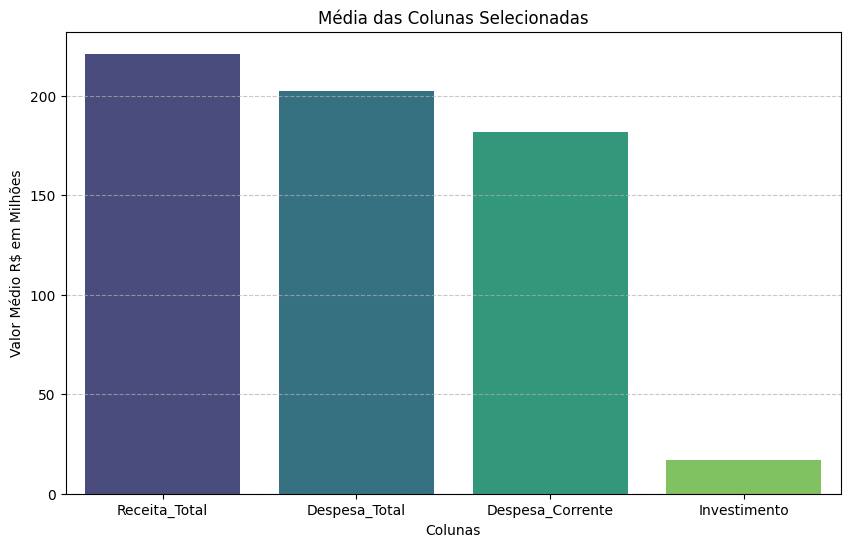

In [118]:
# Colunas que você para exibir a média
colunas_para_media = ['Receita_Total', 'Despesa_Total', 'Despesa_Corrente', 'Investimento']

# Calcula a média das colunas selecionadas
medias = df_real_milhao[colunas_para_media].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=medias.index, y=medias.values, palette='viridis')
plt.title('Média das Colunas Selecionadas')
plt.xlabel('Colunas')
plt.ylabel('Valor Médio R$ em Milhões')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Gráfico com a média das 4 principais contas durante o período de 2018 a 2024 dos Municipíos do Estado do Ceará:
- `Receita_Total`: média da receita total;
- `Despesa_Total`: média da despesa total, incluindo todos os tipos de despesas;
- `Despesa_Corrente`: média da despesa corrente. A despesa corrente nas contas públicas é o conjunto de gastos realizados pelo governo para manter seu funcionamento regular, sem gerar novos bens ou serviços duradouros. Ela cobre principalmente despesas obrigatórias, administrativas e operacionais que ocorrem ano após ano.
- `Investimento`: média do investimento. É uma despesa de capital destinada à aquisição ou construção de bens duradouros que aumentam o patrimônio público ou melhoram os serviços à população.


### Desvio Padrão

O desvio padrão é uma medida de dispersão que quantifica a quantidade de variação ou dispersão de um conjunto de valores. Um desvio padrão baixo indica que os pontos de dados tendem a estar próximos da média do conjunto, enquanto um desvio padrão alto indica que os pontos de dados estão espalhados por uma faixa maior de valores. Ele é a raiz quadrada da variância.

In [119]:
# Desvio padrão dos atributos numéricos do dataset
df_real_milhao.describe().loc['std']

,std
Codigo_Municipio,4029.86
Ano,1.41
Populacao,199387.17
Receita_Total,892.64
Receita_Exceto_Intra,840.64
Receita_Corrente,783.18
Receita_Capital,64.36
Receita_Intra,52.77
Receita_Intra_Corrente,52.77
Receita_Intra_Capital,0.48


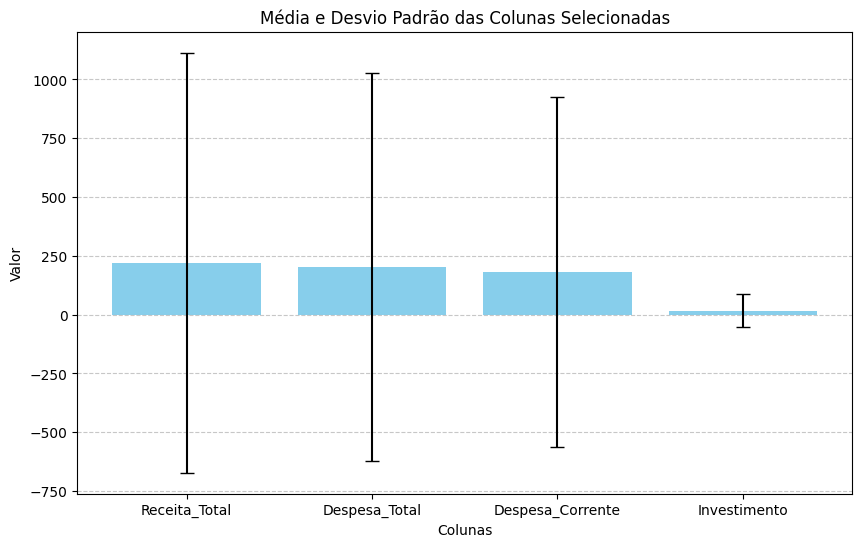

In [120]:
# Colunas que exibir a média e o desvio padrão
colunas_para_analise = ['Receita_Total', 'Despesa_Total', 'Despesa_Corrente', 'Investimento']

# Calcular as médias e desvios padrão
medias = df_real_milhao[colunas_para_analise].mean()
desvios_padrao = df_real_milhao[colunas_para_analise].std()

# Criar um DataFrame para facilitar a plotagem
df_plot = pd.DataFrame({
    'Média': medias,
    'Desvio Padrão': desvios_padrao
})

plt.figure(figsize=(10, 6))
# Usamos barras de erro para representar o desvio padrão
plt.bar(df_plot.index, df_plot['Média'], yerr=df_plot['Desvio Padrão'], capsize=5, color='skyblue')
plt.title('Média e Desvio Padrão das Colunas Selecionadas')
plt.xlabel('Colunas')
plt.ylabel('Valor')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Observamos que:
- Grande desvio padrão em **`Receita`**, **`Despesa Total`** e **`Despesa Corrente`** em realação às médias, indica grande desigualdade entre os Municípios.

- **`Despesas Correntes`** dominam o orçamento dos entes públicos, com média próxima à despesa total.
- **`Investimentos`** são muito pequenos em comparação — representam uma pequena fração do orçamento.
- O baixo desvio padrão de **`Investimentos`** sugere que mesmo os Municípios com maiores orçamentos não investem proporcionalmente mais, o investimento é geralmente baixo em todos.

## Matriz de Correlação

A matriz de correlação mede a força e a direção de uma relação linear que os atributos numéricos das contas podem ter. Valores próximos a 1 indicam uma forte correlação positiva, -1 uma forte correlação negativa, e 0 ausência de correlação linear.

Matriz de Correlação para as Contas Selecionadas:

                  Receita_Total  Receita_Corrente  Despesa_Total  \
Receita_Total              1.00              1.00           1.00   
Receita_Corrente           1.00              1.00           1.00   
Despesa_Total              1.00              1.00           1.00   
Despesa_Corrente           1.00              1.00           1.00   
Despesa_Capital            0.98              0.98           0.98   
Investimento               0.97              0.97           0.98   

                  Despesa_Corrente  Despesa_Capital  Investimento  
Receita_Total                 1.00             0.98          0.97  
Receita_Corrente              1.00             0.98          0.97  
Despesa_Total                 1.00             0.98          0.98  
Despesa_Corrente              1.00             0.98          0.97  
Despesa_Capital               0.98             1.00          1.00  
Investimento                  0.97             1.00          1.0

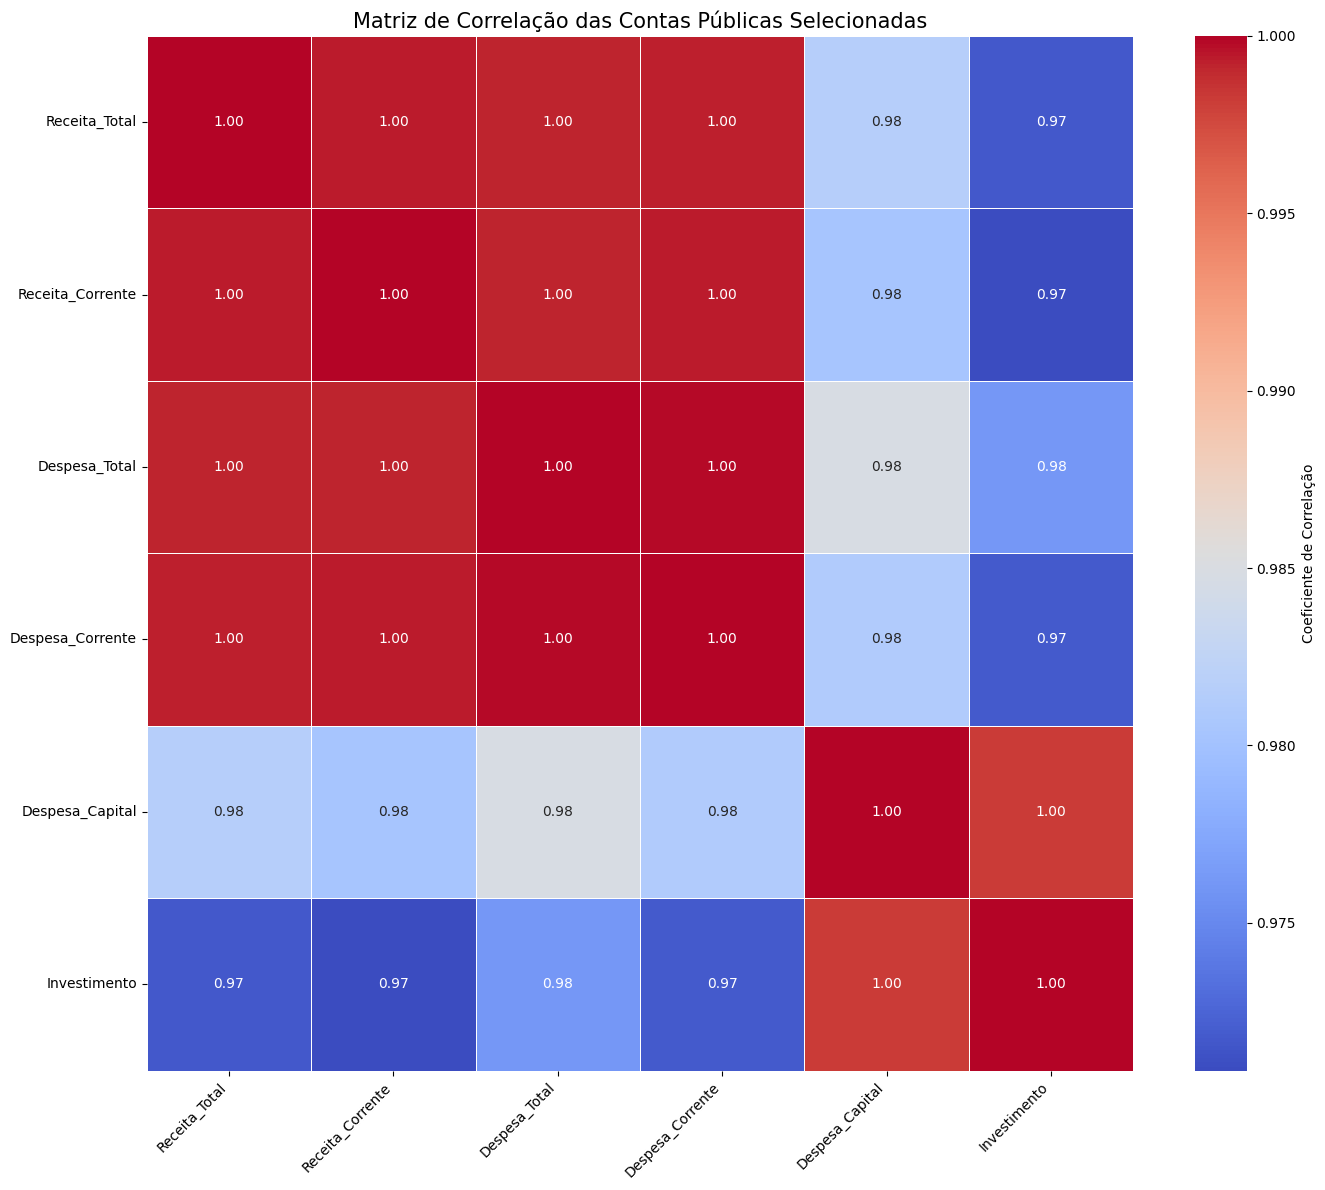

In [121]:

# Selecionar APENAS as colunas que você serão utilizadas na matriz de correlação ---
colunas_para_correlacao = [
    'Receita_Total', 'Receita_Corrente',
    'Despesa_Total', 'Despesa_Corrente',
    'Despesa_Capital', 'Investimento'
]

# Filtrar o DataFrame para conter apenas essas colunas
df_para_corr = df_real_milhao[colunas_para_correlacao]

# Criar a Matriz de Correlação ---
matriz_correlacao = df_para_corr.corr()

print("Matriz de Correlação para as Contas Selecionadas:\n")
print(matriz_correlacao)

# Visualizar a Matriz de Correlação como um Heatmap ---
plt.figure(figsize=(14, 12)) # Ajusta o tamanho para uma matriz maior
sns.heatmap(
    matriz_correlacao,
    annot=True,     # Mostra os valores de correlação
    cmap='coolwarm',# Azul para correlação positiva, vermelho para negativa
    fmt=".2f",      # Formata os valores com 2 casas decimais
    linewidths=.5,  # Adiciona linhas entre as células
    cbar_kws={'label': 'Coeficiente de Correlação'} # Adiciona rótulo à barra de cor
)
plt.title('Matriz de Correlação das Contas Públicas Selecionadas', fontsize=15)
plt.xticks(rotation=45, ha='right') # Rotaciona rótulos do eixo X para melhor legibilidade
plt.yticks(rotation=0) # Mantém rótulos do eixo Y na horizontal
plt.tight_layout() # Ajusta o layout para garantir que tudo caiba na figura
plt.savefig('matriz_correlacao_contas_publicas.png', dpi=300) # Salva o gráfico
plt.show()

### Interpretação do coeficiente de correlação:

Valor	Interpretação:

- +1.00	Correlação perfeita e positiva
- 0.70 a 0.99	Correlação forte positiva
- 0.40 a 0.69	Correlação moderada positiva (não apareceu no gráfico)
- 0.00 a 0.39	Correlação fraca ou nula
Valores negativos	Correlação negativa (não apareceu no gráfico)

Com base na matriz de correlação, podemos tirar as seguintes conclusões:

**1. Relações Extremamente Fortes e Positivas**

Todas as variáveis apresentadas (`Receita Total`, `Receita Corrente`, `Despesa Total`, `Despesa Corrente`, `Despesa de Capital` e `Investimento`) têm uma correlação extremamente alta e positiva entre si. A correlação em todos os pares é igual ou superior a 0,97. Isso significa que, neste conjunto de dados, todas as contas públicas selecionadas tendem a se mover na mesma direção de forma muito previsível. Quando uma aumenta, as outras também aumentam.


**2. Relações Perfeitas (Correlação = 1,00)**

A matriz revela várias correlações perfeitas, que indicam uma relação linear e direta entre as variáveis. As mais notáveis são:

`Receita Total` e `Receita Corrente`: A correlação de 1,00 sugere que a `Receita Corrente` é o principal componente da `Receita Total` e que ambas se comportam de maneira idêntica.

`Despesa Total` e `Despesa Corrente`: Da mesma forma, a `Despesa Corrent`e é perfeitamente correlacionada com a `Despesa Total`, indicando uma dependência total.

`Receita Total` e `Despesa Total`: A correlação de 1,00 entre a `Receita Total` e a `Despesa Total` é um dos pontos mais importantes. Isso indica que, para este conjunto de dados, cada aumento na receita é acompanhado por um aumento perfeitamente proporcional na despesa.

**3. Relações Fortes, mas não Perfeitas (Correlação < 1,00)**

As contas de capital (`Despesa de Capital` e `Investimento`) têm uma correlação ligeiramente menor (em torno de 0,97 e 0,98) com as contas de receita e despesa correntes. Embora a relação ainda seja muito forte, não é perfeita. Isso sugere que, embora o investimento e o gasto de capital acompanhem o crescimento geral da receita e da despesa, a proporção exata pode variar um pouco, ao contrário das contas "Total" e "Corrente" que se movem em um ritmo idêntico.

Em resumo, a principal conclusão é que todas as contas públicas analisadas estão fortemente interligadas e se movem em uníssono. A matriz sugere um cenário de finanças públicas onde os orçamentos são rigidamente controlados, com as despesas aumentando de forma quase exata em resposta ao crescimento das receitas.


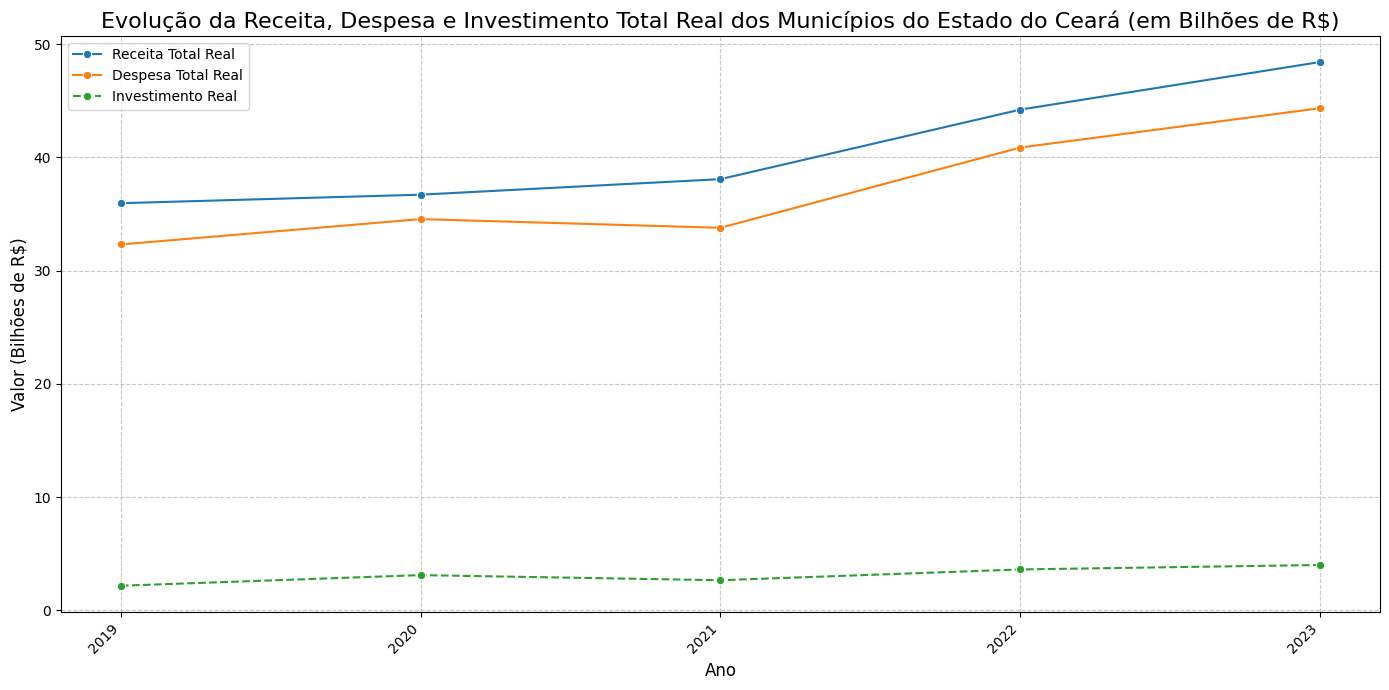


Dados agregados para a evolução anual (Receita, Despesa e Investimento em Bilhões de R$):
    Ano  Receita_Total  Despesa_Total  Investimento
0  2019          35.96          32.31          2.18
1  2020          36.71          34.55          3.12
2  2021          38.08          33.78          2.66
3  2022          44.22          40.87          3.62
4  2023          48.42          44.35          4.01


In [122]:
# Agrupar os dados por 'Ano' e somar as colunas de interesse
# As colunas em 'df_real_bilhao' já estão em bilhoes de R$.
evolucao_anual = df_real_bilhao.groupby('Ano')[['Receita_Total', 'Despesa_Total', 'Investimento']].sum().reset_index()

# Criar o gráfico de linha
plt.figure(figsize=(14, 7)) # Tamanho do gráfico para melhor visualização

# Linha para Receita Total
sns.lineplot(data=evolucao_anual, x='Ano', y='Receita_Total', marker='o', label='Receita Total Real')

# Linha para Despesa Total
sns.lineplot(data=evolucao_anual, x='Ano', y='Despesa_Total', marker='o', label='Despesa Total Real')

# Linha para Investimento
sns.lineplot(data=evolucao_anual, x='Ano', y='Investimento', marker='o', label='Investimento Real', linestyle='--') # Adicionando um linestyle
#diferente para destacar

# Adicionar título e rótulos
plt.title('Evolução da Receita, Despesa e Investimento Total Real dos Municípios do Estado do Ceará (em Bilhões de R$)', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Valor (Bilhões de R$)', fontsize=12)

# Adicionar grade para facilitar a leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Adicionar legenda
plt.legend(fontsize=10)

# Ajustar os ticks do eixo X para mostrar todos os anos, se possível
plt.xticks(evolucao_anual['Ano'].unique(), rotation=45, ha='right')

# Melhorar o layout para evitar cortes
plt.tight_layout()

# Mostrar o gráfico
plt.show()

print("\nDados agregados para a evolução anual (Receita, Despesa e Investimento em Bilhões de R$):")
print(evolucao_anual)

A `Receita_Total` e o `Investimento` não são uniformes no decorrer da série temporal, mas apresentam uma inclinação mais ascendente a partir de 2021. Observa-se por outro lado que a linha tracejada do investimento não aconpanha essa tendência, permanecendo quase que uma reta no mesmo período a partir de 2021.



Primeiras linhas do DataFrame com os novos percentuais:
    Ano Município  Investimento  Despesa_Total  Perc_Investimento_Despesa
0  2019   Abaiara          2.31          40.42                       5.71
1  2020   Abaiara          2.06          39.61                       5.20
2  2021   Abaiara          0.92          40.73                       2.27
3  2022   Abaiara          1.72          47.38                       3.64
4  2023   Abaiara          4.54          57.46                       7.89


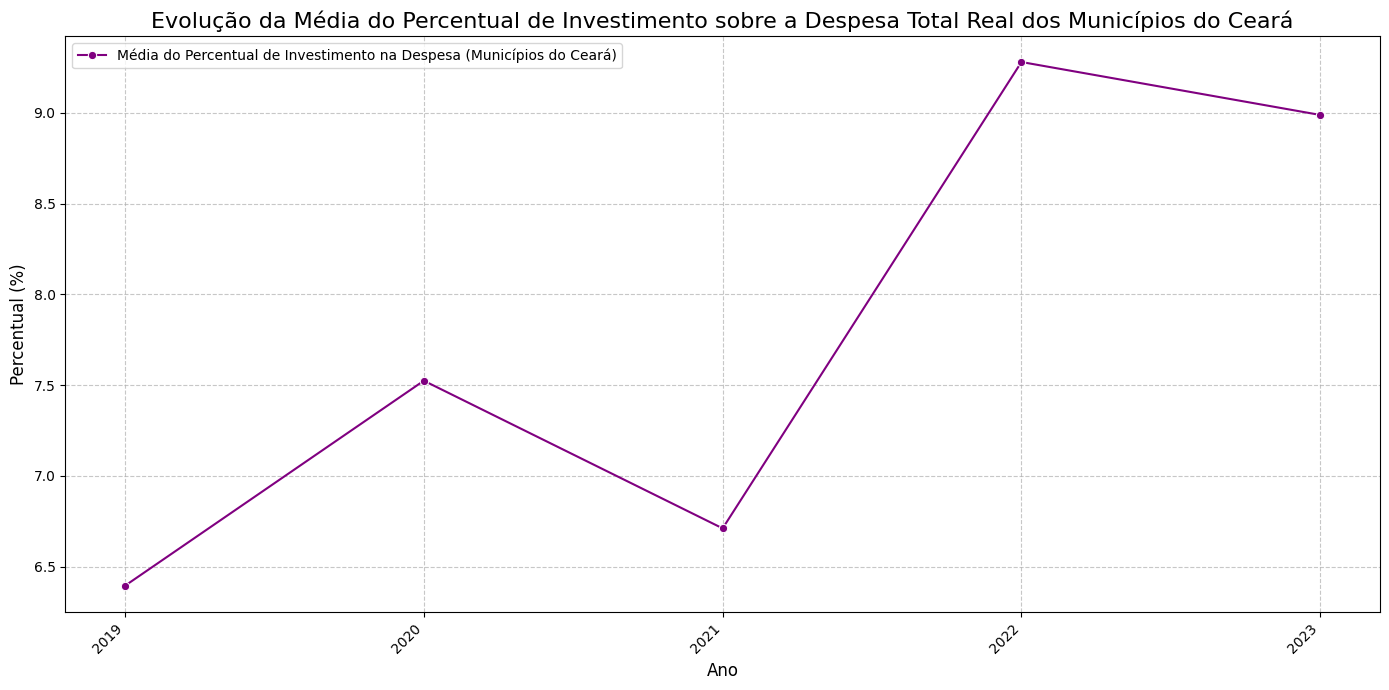

In [123]:
# Calcular o percentual de Investimento sobre a Despesa Total
df_com_percentuais = df_real_milhao.copy()

# Evitar divisão por zero
df_com_percentuais['Perc_Investimento_Despesa'] = (
    df_com_percentuais['Investimento'] / df_com_percentuais['Despesa_Total']
) * 100

print("Primeiras linhas do DataFrame com os novos percentuais:")
print(df_com_percentuais[['Ano', 'Município', 'Investimento', 'Despesa_Total', 'Perc_Investimento_Despesa']].head())

# Agrupar para ver a média anual do percentual
evolucao_perc_investimento_anual = df_com_percentuais.groupby('Ano')['Perc_Investimento_Despesa'].mean().reset_index()

# Criar o gráfico de linha para o percentual médio
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=evolucao_perc_investimento_anual,
    x='Ano',
    y='Perc_Investimento_Despesa',
    marker='o',
    color='purple',
    label='Média do Percentual de Investimento na Despesa (Municípios do Ceará)'
)

plt.title('Evolução da Média do Percentual de Investimento sobre a Despesa Total Real dos Municípios do Ceará', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.xticks(evolucao_perc_investimento_anual['Ano'].unique(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

Evolução média do percentual de **`Investimento`** sobre a **`Despesa Total Real`** dos Municípios apresenta um aumento acentuado entre os anos de 2021 a 2022. Isso pode ser um indicativo de gastos com o episódio da pandemia de COVID-19 que obrigou todos os entes públicos a aumentarem significativamente seus investimentos na saúde pública. Entre 2022 a 2023 ocorre uma queda no percentual.

Somatório Total de Despesa por Município do Ceará (todos os anos no DataFrame):

                   Município  Despesa_Total
58                 Fortaleza          55.35
43                   Caucaia           6.45
103                Maracanaú           5.53
162                   Sobral           5.38
98         Juazeiro do Norte           4.19
87                 Itapipoca           2.58
55                   Eusébio           2.56
50                     Crato           2.39
165  São Gonçalo do Amarante           2.23
11                   Aquiraz           2.07
22                  Barbalha           1.85
76                    Iguatu           1.83
12                   Aracati           1.76
104               Maranguape           1.72
70                 Horizonte           1.58
150             Quixeramobim           1.56
33                   Canindé           1.55
148                  Quixadá           1.54
173                  Tianguá           1.45
154                   Russas           

/tmp/ipython-input-3658428170.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Despesa_Total', y='Município', data=top_23_municipios, palette='viridis')


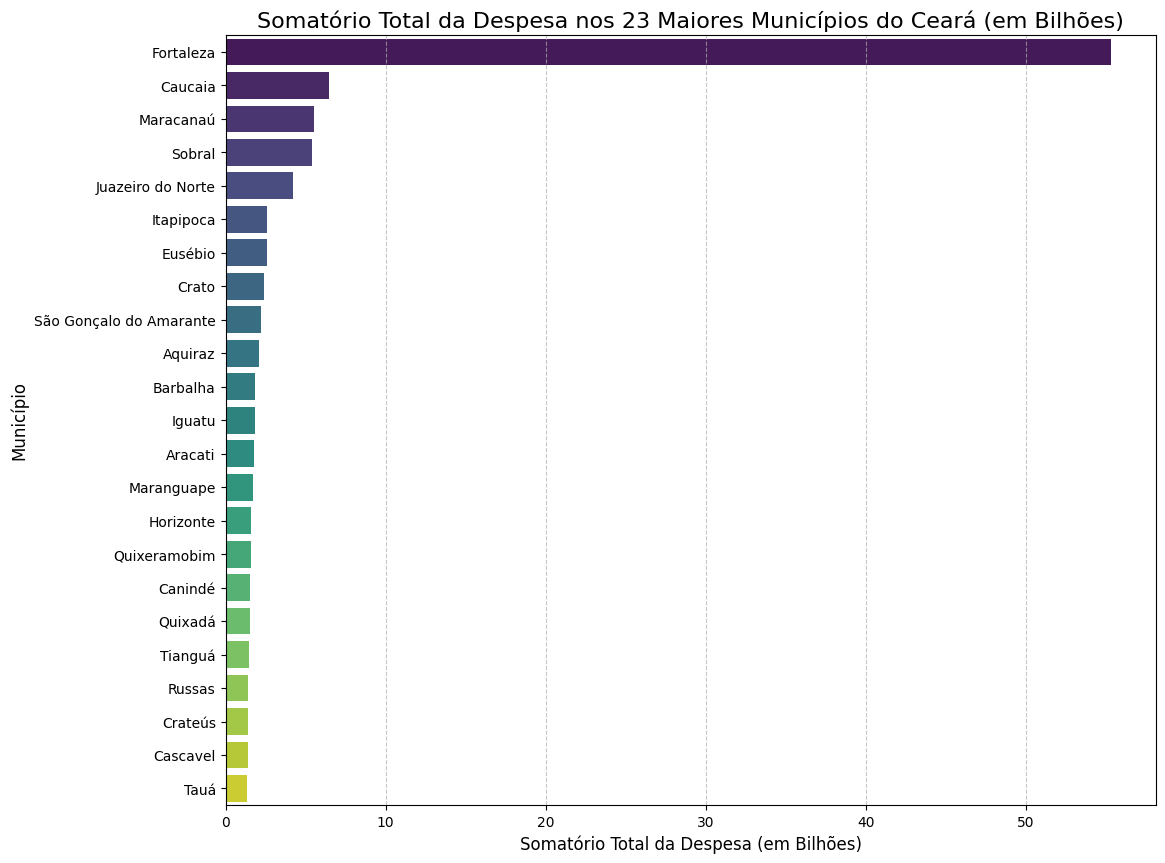

In [124]:
# O DataFrame de entrada é o 'df_real_bilhao' com os valores em bilhões
# e as colunas de municípios.

# Calcula o somatório da Despesa Total por Município
despesa_total_por_municipio = df_real_bilhao.groupby('Município')['Despesa_Total'].sum().reset_index()

# Ordena os dados para facilitar a leitura do gráfico (maior para o menor)
despesa_total_por_municipio = despesa_total_por_municipio.sort_values(by='Despesa_Total', ascending=False)

print("Somatório Total de Despesa por Município do Ceará (todos os anos no DataFrame):\n")
print(despesa_total_por_municipio.head(23))


# --- Plotando os dados ---

# Seleciona os 23 primeiros municípios
top_23_municipios = despesa_total_por_municipio.head(23)

plt.figure(figsize=(12, 10)) # Ajusta o tamanho da figura para acomodar as 23 barras

# Cria o gráfico de barras horizontal (invertido)
sns.barplot(x='Despesa_Total', y='Município', data=top_23_municipios, palette='viridis')

plt.title('Somatório Total da Despesa nos 23 Maiores Municípios do Ceará (em Bilhões)', fontsize=16)
plt.xlabel('Somatório Total da Despesa (em Bilhões)', fontsize=12)
plt.ylabel('Município', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

O estado do **Ceará** tem **184 municípios**, para o gráfico acima não ficar com muita informação visual foi restringido a exibição para **12,5%** do total de municípios, totalizando exatamente **23**.

Percebe-se visualmente uma enorme disparidade do primeiro lugar em gastos comparando com os demais. `Fortaleza` gastou no período 5**5 bilhões e 400 milhões** de reais. Enquanto isso os demais 23 gastaram **53 bilhões e 770 milhões** de reais. Ou seja a capital do Ceará gastou mais que os outros **22** **municípios** juntos.


Somatório de Investimento por Município do Ceará:

                   Município  Investimento
58                 Fortaleza          4.49
43                   Caucaia          0.78
162                   Sobral          0.62
103                Maracanaú          0.54
12                   Aracati          0.32
98         Juazeiro do Norte          0.30
87                 Itapipoca          0.25
50                     Crato          0.21
11                   Aquiraz          0.19
55                   Eusébio          0.17
70                 Horizonte          0.17
165  São Gonçalo do Amarante          0.16
62                    Granja          0.16
89                   Itarema          0.14
127                 Pacatuba          0.14
171                     Tauá          0.14
134                  Parambu          0.13
30               Brejo Santo          0.13
2                     Acaraú          0.12
29                Boa Viagem          0.12
122              Nova Russas          0.12
126

/tmp/ipython-input-2495853549.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Investimento', y='Município', data=top_23_municipios_inv, palette='viridis')


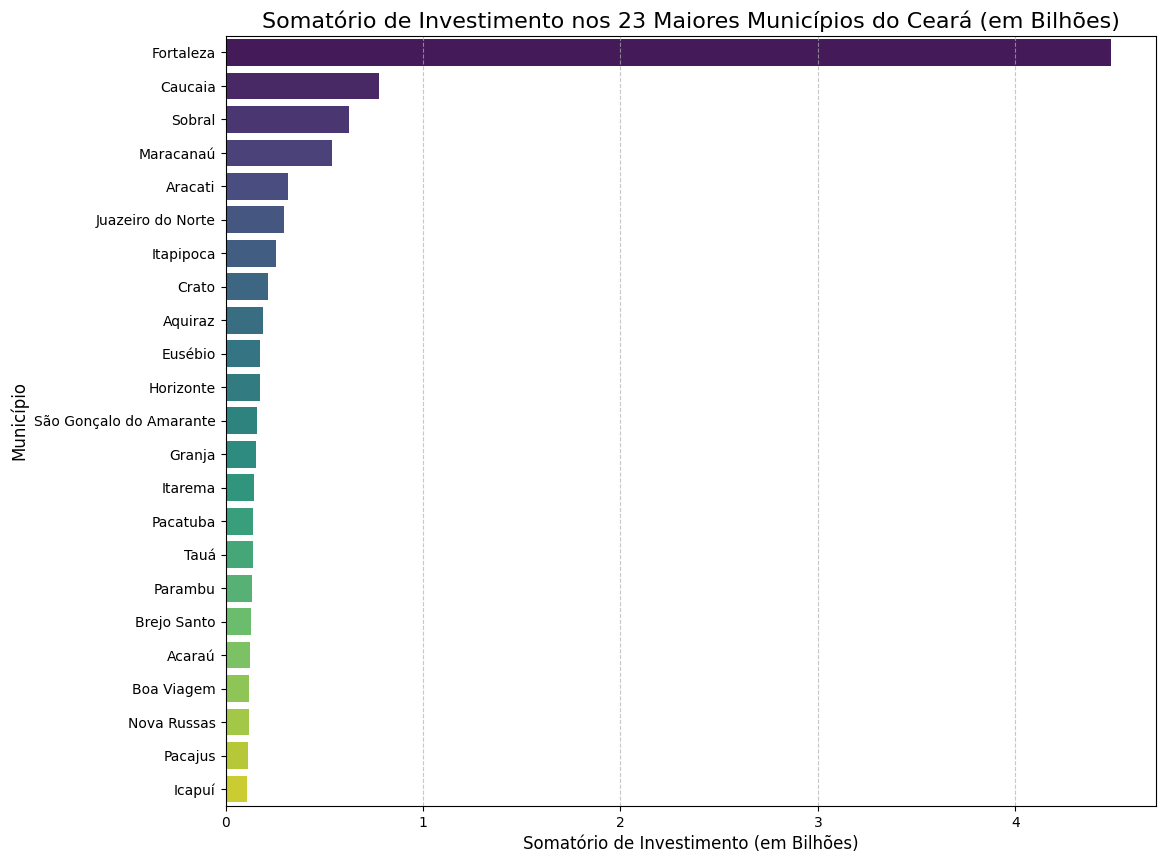

In [125]:
# O DataFrame de entrada é o 'df_real_bilhao' com os valores em bilhões
# e as colunas de municípios.

# Calcula o somatório do Investimento por Município
investimento_por_municipio = df_real_bilhao.groupby('Município')['Investimento'].sum().reset_index()

# Ordena os dados para o gráfico ser mais fácil de ler, do maior para o menor
investimento_por_municipio = investimento_por_municipio.sort_values(by='Investimento', ascending=False)

print("Somatório de Investimento por Município do Ceará:\n")
print(investimento_por_municipio.head(23))


# --- Plotando os dados ---

# Seleciona os 23 primeiros municípios
top_23_municipios_inv = investimento_por_municipio.head(23)

plt.figure(figsize=(12, 10)) # Ajusta o tamanho da figura para acomodar as 23 barras

# Cria o gráfico de barras horizontal
sns.barplot(x='Investimento', y='Município', data=top_23_municipios_inv, palette='viridis')

plt.title('Somatório de Investimento nos 23 Maiores Municípios do Ceará (em Bilhões)', fontsize=16)
plt.xlabel('Somatório de Investimento (em Bilhões)', fontsize=12)
plt.ylabel('Município', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

```
Cód.Município      Município    Investimento
58                 Fortaleza       4485.45
43                   Caucaia        777.12
162                   Sobral        623.51
103                Maracanaú        537.72
12                   Aracati        317.23
98         Juazeiro do Norte        297.99
87                 Itapipoca        253.84
50                     Crato        214.05
11                   Aquiraz        188.06
55                   Eusébio        174.84
70                 Horizonte        172.13
165  São Gonçalo do Amarante        158.13
62                    Granja        155.95
89                   Itarema        142.84
127                 Pacatuba        141.45
171                     Tauá        137.64
134                  Parambu        134.83
30               Brejo Santo        129.09
2                     Acaraú        124.63
29                Boa Viagem        116.86
122              Nova Russas        116.78
126                  Pacajus        114.37
74                    Icapuí        109.10

```



Analisando o somatório do **`Investimento`**, também restringindo a visualizacão para **12,5%** do total de municípios, totalizando exatamente **23**.
Visualmente continua a disparidade do primeiro lugar em gastos comparando com os demais. `Fortaleza` investiu no período **4 bilhões e 485 milhões** de reais. Enquanto isso os demais **22** gastaram **5 bilhões e 138 milhões** reais.

Pela ótica do **`Investimento`** em valores brutos os outros 22 municípios superaram `Fortaleza` no total investido, o que pela relação anterior não aconteceu (**`Despesa Total`**).

Olhar apenas para números absolutos pode indicar que a capital do Ceará estar à frente de todos os outros municípios do estado nesses quesitos analisados, bem como outros indicadores que tenham relação com o presente objeto de estudo.

In [126]:
# Para garantir a exibição do número completo, sem notação científica
pd.set_option('display.float_format', '{:,.2f}'.format)


# Calcular o investimento per capita para TODOS os municípios
# O cálculo é feito no DataFrame original
df_real_milhao['Investimento_Per_Capita'] = np.where(
    df_real_milhao['Populacao'] > 0,
    df_real_milhao['Investimento'] / df_real_milhao['Populacao'],
    0
)

# Converter o valor de "milhões por pessoa" para "reais por pessoa"
df_real_milhao['Investimento_Per_Capita_Reais'] = df_real_milhao['Investimento_Per_Capita'] * 1_000_000

# Calcular a média do investimento per capita para CADA MUNICÍPIO
# Agrupamento feito em todo o DataFrame, não apenas nos top 23
media_por_municipio = df_real_milhao.groupby('Município')['Investimento_Per_Capita_Reais'].mean().reset_index()

# Opcional: Ordenar para ver os que mais investem no topo da lista
media_por_municipio = media_por_municipio.sort_values(by='Investimento_Per_Capita_Reais', ascending=False)

# Exibir o resultado final em um formato claro
print("Média do Investimento PER CAPITA por Município (em Reais):\n")
print(media_por_municipio)

Média do Investimento PER CAPITA por Município (em Reais):

      Município  Investimento_Per_Capita_Reais
74       Icapuí                       1,087.50
63    Granjeiro                         986.33
146  Potiretama                         982.50
134     Parambu                         858.13
12      Aracati                         846.42
..          ...                            ...
3      Acopiara                         114.51
34   Capistrano                         101.10
175      Tururu                          91.18
24        Barro                          88.26
148     Quixadá                          76.17

[184 rows x 2 columns]


Se levarmos em consideração o `fator populacional`, veremos que o cenário acima
muda. Cidades que lideravam em volume absoluto agora estão no meio ou na parte de baixo do gráfico. Fortaleza, até então líder absoluto, está agora em **`72º lugar`**. Isso acontece porque seu enorme volume de investimento é "diluído" por sua população igualmente massiva. Em contrapartida, o topo do ranking é agora ocupado por cidades com populações menores. Nesses locais, um volume de investimento que seria modesto para Fortaleza tem um grande impacto per capita.

Nessa perspectiva, a **`média per capta de investimento por habitante`** (mensura o montante de investimento direcionado, em média, a cada cidadão) em reais para o período analisado em cada município do estado do Ceará mostra a importância de um olhar a partir de um outro critério.


/tmp/ipython-input-1321828123.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


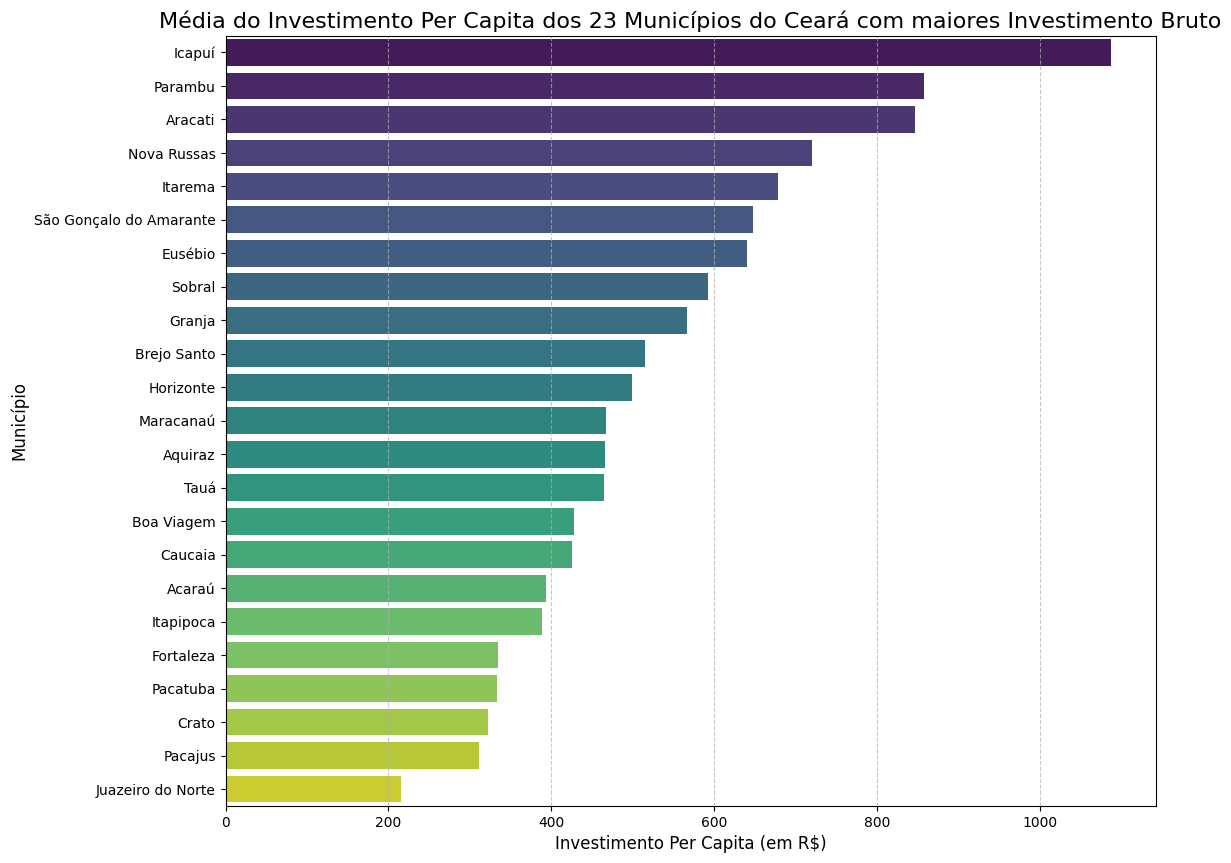

In [127]:
# Para garantir a exibição do número completo, sem notação científica
pd.set_option('display.float_format', '{:,.2f}'.format)


# Encontrar os 23 municípios com maior investimento total
investimento_total = df_real_milhao.groupby('Município')['Investimento'].sum().reset_index()
investimento_total = investimento_total.sort_values(by='Investimento', ascending=False)
top_23_municipios = investimento_total.head(23)
nomes_top_23 = top_23_municipios['Município'].tolist()

# Filtrar o DataFrame original para incluir apenas os top 23
df_top_23 = df_real_milhao[df_real_milhao['Município'].isin(nomes_top_23)].copy()

# Garante que as colunas 'populacao' e 'Investimento' sejam numéricas
df_top_23['Populacao'] = pd.to_numeric(df_top_23['Populacao'], errors='coerce')
df_top_23['Investimento'] = pd.to_numeric(df_top_23['Investimento'], errors='coerce')
df_top_23.dropna(subset=['Populacao', 'Investimento'], inplace=True)

# Calcular o investimento per capita para os 23 municípios
df_top_23['Investimento_Per_Capita'] = np.where(
    df_top_23['Populacao'] > 0,
    df_top_23['Investimento'] / df_top_23['Populacao'],
    0
)

# Converter o valor de "milhões por pessoa" para "reais por pessoa"
df_top_23['Investimento_Per_Capita_Reais'] = df_top_23['Investimento_Per_Capita'] * 1_000_000

# Calcular a média do investimento per capita para CADA MUNICÍPIO
media_por_municipio = df_top_23.groupby('Município')['Investimento_Per_Capita_Reais'].mean().reset_index()
media_por_municipio = media_por_municipio.sort_values(by='Investimento_Per_Capita_Reais', ascending=False)


# --- ADIÇÃO: Código para Plotar o Gráfico de Barras Horizontais ---
plt.figure(figsize=(12, 10)) # Ajusta o tamanho da figura para acomodar as 23 barras

# Cria o gráfico de barras horizontais
sns.barplot(
    x='Investimento_Per_Capita_Reais',
    y='Município',
    data=media_por_municipio,
    palette='viridis'
)

plt.title('Média do Investimento Per Capita dos 23 Municípios do Ceará com maiores Investimento Bruto', fontsize=16)
plt.xlabel('Investimento Per Capita (em R$)', fontsize=12)
plt.ylabel('Município', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

A lista acima que mostra o **`Investimento Per Capta`** das 23 cidades que mais gastam com `Investimento em Valores Brutos`. A cidade de `Icapuí` que aparecia na última colocação em um gráfico mais acima que mostra as 23 cidades do Estado que mais investem em valores brutos, agora assume a liderança quando se analisa o `Investimento Per Capta`.

In [128]:
# Lista das cidades incluídas na análise
cidades_selecionadas = [
    'Fortaleza',
    'Caucaia',
    'Sobral',
    'Maracanaú',
    'Aracati',
    'Juazeiro do Norte',
    'Itapipoca',
    'Crato',
    'Aquiraz',
    'Eusébio'
]

# Filtra o DataFrame para selecionar apenas as linhas onde o Município está na lista
dados_cidades_selecionadas = df_real_milhao[df_real_milhao['Município'].isin(cidades_selecionadas)].copy()

# Exibe a população ano a ano para cada cidade selecionada
print("População das cidades selecionadas, ano a ano:\n")
if not dados_cidades_selecionadas.empty:
    # A coluna `Populacao` já foi limpa e formatada em passos anteriores
    print(dados_cidades_selecionadas[['Município', 'Ano', 'Populacao']].sort_values(by=['Município', 'Ano']))
else:
    print("Dados para as cidades selecionadas não foram encontrados no DataFrame.")

População das cidades selecionadas, ano a ano:

             Município   Ano  Populacao
55             Aquiraz  2019      79563
56             Aquiraz  2020      80271
57             Aquiraz  2021      80935
58             Aquiraz  2022      81581
59             Aquiraz  2023      81581
60             Aracati  2019      74084
61             Aracati  2020      74547
62             Aracati  2021      74975
63             Aracati  2022      75392
64             Aracati  2023      75392
215            Caucaia  2019     363982
216            Caucaia  2020     361400
217            Caucaia  2021     365212
218            Caucaia  2022     368918
219            Caucaia  2023     368918
250              Crato  2019     131372
251              Crato  2020     132123
252              Crato  2021     133031
253              Crato  2022     133913
254              Crato  2023     133913
275            Eusébio  2019      52880
276            Eusébio  2020      53618
277            Eusébio  2021    

**População** das 10 que mais gastam com `Investimento em Valores Brutos`. Fortaleza tem uma concentração populacional (quase 10X maior se comparado a segunda cidade mais populosa Caucaia.

Fortaleza a capital do estado do Ceará possui uma concentração populacional massiva, com 2.703.391 no ano de 2023. Esse número representa mais de 7 vezes a populaçao do município que fica em segundo lugar em termos populacional, Caucaia com 368.918 pessoas no mesmo ano.

In [129]:
# Para garantir a exibição do número completo, sem notação científica
pd.set_option('display.float_format', '{:,.2f}'.format)


# Calcular o investimento per capita para TODOS os municípios
# O cálculo é feito no DataFrame original
df_real_milhao['Investimento_Per_Capita'] = np.where(
    df_real_milhao['Populacao'] > 0,
    df_real_milhao['Investimento'] / df_real_milhao['Populacao'],
    0
)

# Converter o valor de "milhões por pessoa" para "reais por pessoa"
df_real_milhao['Investimento_Per_Capita_Reais'] = df_real_milhao['Investimento_Per_Capita'] * 1_000_000

# Calcular a média CONSOLIDADA de toda a coluna
media_consolidada = df_real_milhao['Investimento_Per_Capita_Reais'].mean()

# Exibir o resultado final em um formato claro
print("Média Consolidada do Investimento Per Capita para todos os Municípios do Ceará para o período analisado:")
print(f"R$ {media_consolidada:,.2f} por pessoa.")

# Para retornar à formatação padrão do Pandas, se necessário
# pd.reset_option('display.float_format')

Média Consolidada do Investimento Per Capita para todos os Municípios do Ceará para o período analisado:
R$ 345.71 por pessoa.


In [130]:
# Para garantir a exibição do número completo, sem notação científica
pd.set_option('display.float_format', '{:,.2f}'.format)


# Calcular o investimento per capita para TODOS os municípios
# O cálculo é feito no DataFrame original
df_real_milhao['Investimento_Per_Capita'] = np.where(
    df_real_milhao['Populacao'] > 0,
    df_real_milhao['Investimento'] / df_real_milhao['Populacao'],
    0
)

# Converter o valor de "milhões por pessoa" para "reais por pessoa"
df_real_milhao['Investimento_Per_Capita_Reais'] = df_real_milhao['Investimento_Per_Capita'] * 1_000_000

# Calcular a média por ano
# O agrupamento por 'Ano' cria uma média para cada ano do período
media_por_ano = df_real_milhao.groupby('Ano')['Investimento_Per_Capita_Reais'].mean().reset_index()

# Exibir o resultado final em um formato claro
print("Média do Investimento Per Capita por Ano (em Reais):\n")
print(media_por_ano)

# Para retornar à formatação padrão do Pandas, se necessário
# pd.reset_option('display.float_format')

Média do Investimento Per Capita por Ano (em Reais):

    Ano  Investimento_Per_Capita_Reais
0  2019                         236.18
1  2020                         293.05
2  2021                         264.19
3  2022                         461.45
4  2023                         473.66



## Definição do Target

Para definir o target será feito as seguintes métricas:

1.	Fazer a média do `Investimento` sobre a `Despesa Total` de todos os  municípios em um determinado ano, e partir desse número classificar os municípios que estão acima e abaixo dessa média nesse mesmo ano. Sendo que os que estão acima da média é positivo, e abaixo da média é negativo;

2.	Fazer a média do `Investimento Per Capta` de todos os municípios em um determinado ano, e partir desse número classificar os municípios que estão acima e abaixo dessa média nesse mesmo ano. Sendo que os que estão acima da média é positivo, e abaixo da média é negativo;

3. Fazer a média da relação `Despesa Corrente` sobre `Receita Total` de todos os municípios em um determinado ano, e partir desse número classificar os que estão acima e abaixo dessa média (inverte-se a lógica das duas anteriores), os que estão acima é negativo pois significa que o orçamento estar com maior comprometimento, e o que estão abaixo é positivo (sobra mais orçamento para investimento);

Feito isso ano a ano será criado 4 categorias (que poderia ser chamado de selo) para classificar os municípios que estão nas seguintes faixas:

`AZUL`: o município atingiu os três parâmetros positivos em um determinado  ano;

`VERDE`: o município atingiu dois parâmetros positivos em um determinado ano;

`AMARELO`: o município atingiu somente 1 parâmetro positivo em um determinado ano;

`VERMELHO`: nível crítico, o município não atingiu nenhum parâmetro em um determinado ano.




In [131]:
# --- PASSO 1: CALCULAR AS MÉTRICAS DE BASE ---

# Métrica 1: Investimento / Despesa Total
# O .replace e .fillna(0) evitam erros se a Despesa_Total ou Receita_Total for zero.
df_real_milhao['Perc_Invest_Despesa'] = (df_real_milhao['Investimento'] / df_real_milhao['Despesa_Total']).replace([np.inf, -np.inf], 0).fillna(0)

# Métrica 2: Investimento Per Capita
if 'Investimento_Per_Capita_Reais' not in df_real_milhao.columns:
    # O valor de investimento está em milhões, então multiplicamos para ter o valor real por pessoa
    df_real_milhao['Investimento_Per_Capita_Reais'] = ((df_real_milhao['Investimento'] * 1000000) / df_real_milhao['Populacao']).fillna(0)

# Métrica 3: Despesa Corrente / Receita Total
df_real_milhao['Perc_DespCor_Receita'] = (df_real_milhao['Despesa_Corrente'] / df_real_milhao['Receita_Total']).replace([np.inf, -np.inf], 0).fillna(0)


# --- PASSO 2: CALCULAR AS MÉDIAS DE CADA ANO ---
# Usamos .groupby('Ano').transform('mean') para que a média de cada ano
# seja adicionada a cada linha correspondente àquele ano.
df_real_milhao['media_anual_inv_desp'] = df_real_milhao.groupby('Ano')['Perc_Invest_Despesa'].transform('mean')
df_real_milhao['media_anual_inv_pc'] = df_real_milhao.groupby('Ano')['Investimento_Per_Capita_Reais'].transform('mean')
df_real_milhao['media_anual_desp_rec'] = df_real_milhao.groupby('Ano')['Perc_DespCor_Receita'].transform('mean')


# --- PASSO 3: AVALIAR OS MUNICÍPIOS CONTRA AS MÉDIAS ANUAIS ---
# Criando colunas "flag" que recebem 1 se o critério foi atendido e 0 caso contrário.

# Critério 1: Investimento / Despesa Total > Média Anual (positivo)
df_real_milhao['flag_crit1'] = (df_real_milhao['Perc_Invest_Despesa'] > df_real_milhao['media_anual_inv_desp']).astype(int)

# Critério 2: Investimento Per Capita > Média Anual (positivo)
df_real_milhao['flag_crit2'] = (df_real_milhao['Investimento_Per_Capita_Reais'] > df_real_milhao['media_anual_inv_pc']).astype(int)

# Critério 3: Despesa Corrente / Receita Total < Média Anual (positivo, lógica invertida)
df_real_milhao['flag_crit3'] = (df_real_milhao['Perc_DespCor_Receita'] < df_real_milhao['media_anual_desp_rec']).astype(int)


# --- PASSO 4: CRIAR A PONTUAÇÃO E A COLUNA TARGET FINAL ---
# Somamos as flags para obter uma pontuação de 0 a 3
df_real_milhao['pontuacao'] = df_real_milhao['flag_crit1'] + df_real_milhao['flag_crit2'] + df_real_milhao['flag_crit3']

# Mapeamos a pontuação para as categorias de cor
mapeamento_cores = {
    3: 'AZUL',    # Atingiu os 3 critérios
    2: 'VERDE',   # Atingiu 2 critérios
    1: 'AMARELO', # Atingiu 1 critério
    0: 'VERMELHO' # Não atingiu nenhum critério
}
df_real_milhao['target'] = df_real_milhao['pontuacao'].map(mapeamento_cores)


# --- PASSO 5: VERIFICAR O RESULTADO ---
print("Contagem de cada classe na nova coluna 'target':")
print(df_real_milhao['target'].value_counts())

print("\nVisualizando as novas colunas para os primeiros registros:")
print(df_real_milhao[['Município', 'Ano', 'pontuacao', 'target']].head(10))

# Opcional: Remover colunas intermediárias que não serão usadas como features no modelo
# colunas_para_remover = [
#     'media_anual_inv_desp', 'media_anual_inv_pc', 'media_anual_desp_rec',
#     'flag_crit1', 'flag_crit2', 'flag_crit3'
# ]
# df_real_milhao.drop(columns=colunas_para_remover, inplace=True)

Contagem de cada classe na nova coluna 'target':
target
VERMELHO    387
AZUL        241
AMARELO     190
VERDE       102
Name: count, dtype: int64

Visualizando as novas colunas para os primeiros registros:
  Município   Ano  pontuacao    target
0   Abaiara  2019          0  VERMELHO
1   Abaiara  2020          1   AMARELO
2   Abaiara  2021          0  VERMELHO
3   Abaiara  2022          1   AMARELO
4   Abaiara  2023          1   AMARELO
5   Acarape  2019          0  VERMELHO
6   Acarape  2020          0  VERMELHO
7   Acarape  2021          1   AMARELO
8   Acarape  2022          1   AMARELO
9   Acarape  2023          0  VERMELHO


In [132]:
print(df_real_milhao.columns.tolist())


['Município', 'Codigo_Municipio', 'Ano', 'Populacao', 'UF', 'Receita_Total', 'Receita_Exceto_Intra', 'Receita_Corrente', 'Receita_Capital', 'Receita_Intra', 'Receita_Intra_Corrente', 'Receita_Intra_Capital', 'Despesa_Total', 'Despesa_Corrente', 'Despesa_Capital', 'Investimento', 'Investimento_Per_Capita', 'Investimento_Per_Capita_Reais', 'Perc_Invest_Despesa', 'Perc_DespCor_Receita', 'media_anual_inv_desp', 'media_anual_inv_pc', 'media_anual_desp_rec', 'flag_crit1', 'flag_crit2', 'flag_crit3', 'pontuacao', 'target']


## Definição de Features e Target

Nesta etapa são definidas as variáveis de entrada (**features**) e a variável alvo (**target**). Foram removidas do conjunto de treino as colunas de identificação (`Município`, `Codigo_Municipio`, `UF`) e as variáveis derivadas do próprio target (`pontuacao`, `flags`, `media_anual_*`).

Essa remoção é essencial para evitar **data leakage** (vazamento de informação), garantindo que o modelo aprenda apenas a partir de variáveis financeiras e demográficas.



In [133]:
target = "target"

# Colunas a remover (identificadores e variáveis derivadas do target)
drop_cols = [
    "Município", "Codigo_Municipio", "UF",  # identificadores
    "pontuacao", "flag_crit1", "flag_crit2", "flag_crit3",  # regras do target
    "media_anual_inv_desp", "media_anual_inv_pc", "media_anual_desp_rec"  # derivados
]

# Seleciona apenas features limpas
features = [c for c in df_real_milhao.columns if c not in [target] + drop_cols]

X = df_real_milhao[features].copy()
y = df_real_milhao[target].copy()

print("Features usadas:", features)
print("Total de features:", len(features))
print("Target:", target, "| Classes:", y.unique())


Features usadas: ['Ano', 'Populacao', 'Receita_Total', 'Receita_Exceto_Intra', 'Receita_Corrente', 'Receita_Capital', 'Receita_Intra', 'Receita_Intra_Corrente', 'Receita_Intra_Capital', 'Despesa_Total', 'Despesa_Corrente', 'Despesa_Capital', 'Investimento', 'Investimento_Per_Capita', 'Investimento_Per_Capita_Reais', 'Perc_Invest_Despesa', 'Perc_DespCor_Receita']
Total de features: 17
Target: target | Classes: ['VERMELHO' 'AMARELO' 'VERDE' 'AZUL']


## Divisão da Base em Treino/Teste


Os dados foram divididos em **treino (80%)** e **teste (20%)**, com a opção `stratify=y` para manter a proporção entre classes nos dois conjuntos.

Essa estratégia é importante em problemas de classificação com **desbalanceamento de classes**, pois garante que todas as classes estarão representadas em ambas as amostras.



In [134]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)
print("Distribuição treino:\n", y_train.value_counts(normalize=True))
print("Distribuição teste:\n", y_test.value_counts(normalize=True))


Treino: (736, 17) Teste: (184, 17)
Distribuição treino:
 target
VERMELHO   0.42
AZUL       0.26
AMARELO    0.21
VERDE      0.11
Name: proportion, dtype: float64
Distribuição teste:
 target
VERMELHO   0.42
AZUL       0.26
AMARELO    0.21
VERDE      0.11
Name: proportion, dtype: float64


## Baseline


Antes de aplicar modelos mais sofisticados, é construída uma baseline com `DummyClassifier`, que prevê sempre a classe mais frequente. Essa abordagem estabelece um **piso de desempenho** para o problema. Qualquer modelo real precisa superar esse resultado para ser considerado útil.


=== Baseline (classe mais frequente) ===
              precision    recall  f1-score   support

     AMARELO       0.00      0.00      0.00        38
        AZUL       0.00      0.00      0.00        48
       VERDE       0.00      0.00      0.00        21
    VERMELHO       0.42      1.00      0.59        77

    accuracy                           0.42       184
   macro avg       0.10      0.25      0.15       184
weighted avg       0.18      0.42      0.25       184



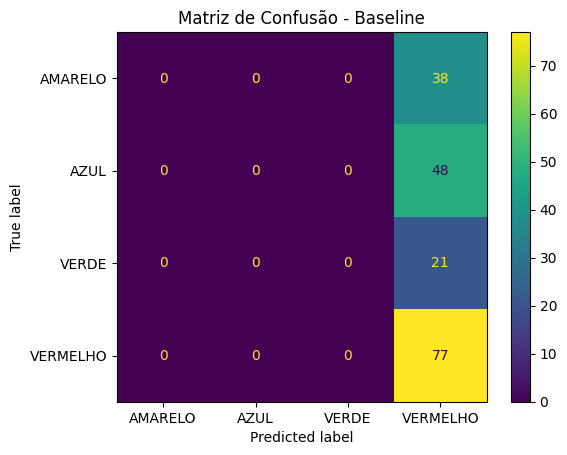

In [135]:

baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

print("=== Baseline (classe mais frequente) ===")
print(classification_report(y_test, y_pred_base, zero_division=0))

ConfusionMatrixDisplay.from_estimator(baseline, X_test, y_test)
plt.title("Matriz de Confusão - Baseline")
plt.show()


## Modelos Reais


Após o baseline, são avaliados dois modelos de classificação:

- **Regressão Logística**: modelo linear, interpretável, usado como baseline mais forte.  
- **Random Forest**: modelo ensemble baseado em múltiplas árvores de decisão, mais robusto para capturar relações complexas entre variáveis.

A comparação entre esses modelos mostra o ganho de performance quando se aplica algoritmos mais sofisticados.



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Regressão Logística ===
              precision    recall  f1-score   support

     AMARELO       0.33      0.05      0.09        38
        AZUL       0.78      0.90      0.83        48
       VERDE       0.00      0.00      0.00        21
    VERMELHO       0.62      0.96      0.75        77

    accuracy                           0.65       184
   macro avg       0.43      0.48      0.42       184
weighted avg       0.53      0.65      0.55       184



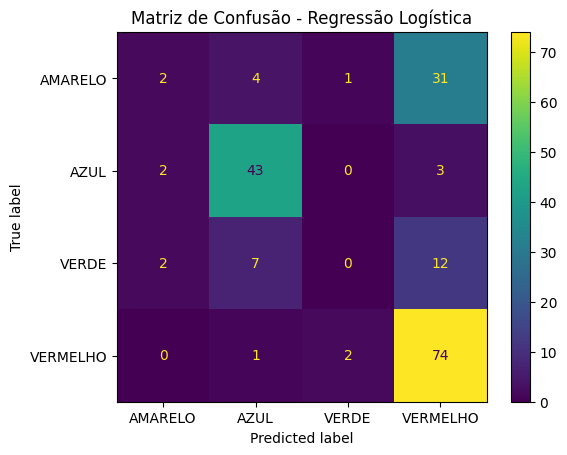

=== Random Forest ===
              precision    recall  f1-score   support

     AMARELO       0.78      0.74      0.76        38
        AZUL       0.94      0.94      0.94        48
       VERDE       0.68      0.71      0.70        21
    VERMELHO       0.91      0.92      0.92        77

    accuracy                           0.86       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.86      0.86      0.86       184



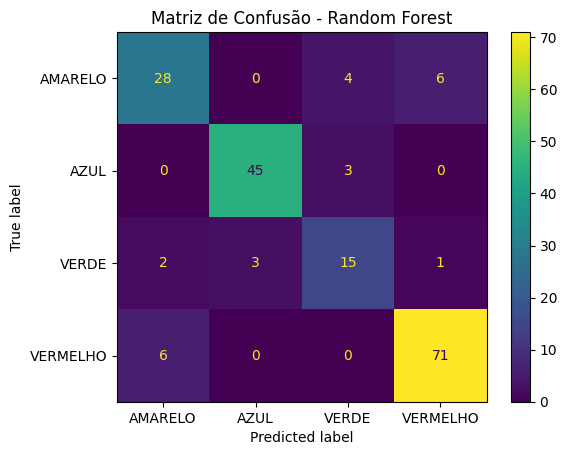

In [136]:


# Regressão Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("=== Regressão Logística ===")
print(classification_report(y_test, y_pred_log, zero_division=0))
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, zero_division=0))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Matriz de Confusão - Random Forest")
plt.show()


## Comparação dos Modelos

Aqui são comparados os desempenhos do `Baseline`, `Regressão Logística` e `Random Forest`. A análise considera métricas de ***Accuracy***, ***F1 Macro*** e ***F1 Weighted***.


In [137]:

resultados = []

def avalia(nome, y_pred):
    f1m = f1_score(y_test, y_pred, average="macro")
    f1w = f1_score(y_test, y_pred, average="weighted")
    acc = accuracy_score(y_test, y_pred)
    resultados.append({"modelo": nome, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w})

avalia("Baseline", y_pred_base)
avalia("LogReg", y_pred_log)
avalia("RandomForest", y_pred_rf)

print("\n=== Comparação ===")
print(pd.DataFrame(resultados).sort_values("f1_macro", ascending=False))



=== Comparação ===
         modelo  accuracy  f1_macro  f1_weighted
2  RandomForest      0.86      0.83         0.86
1        LogReg      0.65      0.42         0.55
0      Baseline      0.42      0.15         0.25


## Interpretação dos resultados

🔹 `Baseline`:

* Accuracy 42%, F1 Macro 0.15.
* Confirma que o dataset é desbalanceado (classe majoritária representa ~42%).
* Esse é o “piso” para comparação.

🔹 `Regressão Logística`:

* Accuracy 65%, mas F1 Macro apenas 0.42.
* Significa que o modelo melhora em relação ao baseline, mas ainda sofre para equilibrar classes minoritárias (VERDE, AMARELO).
* Indica que o dataset não é linearmente separável de forma simples.

🔹 `Random Forest`:

* Accuracy 86%, F1 Macro 0.83.
* Grande salto em relação ao baseline e à LogReg.
* Mostra que o modelo consegue capturar relações mais complexas entre variáveis.
* Esse é a melhor opção.
* Esse resultado reforça a importância do uso de ensembles em problemas de classificação desbalanceados.

## Otimizacao de Hiperparâmetros


Nesta etapa, a **Random Forest** é otimizada com `RandomizedSearchCV`, usando validação cruzada estratificada em 5 folds.

O objetivo é encontrar a melhor combinação de hiperparâmetros para **maximizar o F1 Macro**, garantindo maior equilíbrio entre classes.

A validação cruzada aumenta a robustez do processo, reduzindo a dependência  
da divisão específica entre treino e teste.



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores hiperparâmetros: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'class_weight': 'balanced'}
Melhor F1 macro (CV): 0.8479540211390395

=== Random Forest Otimizada ===
              precision    recall  f1-score   support

     AMARELO       0.85      0.89      0.87        38
        AZUL       0.94      0.92      0.93        48
       VERDE       0.73      0.76      0.74        21
    VERMELHO       0.99      0.96      0.97        77

    accuracy                           0.91       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.92      0.91      0.91       184



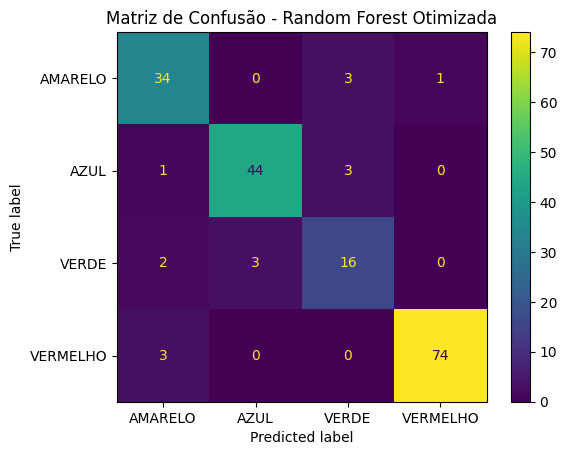

In [138]:

# Espaço de busca de hiperparâmetros
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"]
}

# Modelo base
rf_base = RandomForestClassifier(random_state=42)

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,            # número de combinações testadas (pode aumentar)
    cv=cv,
    scoring="f1_macro",   # métrica usada para otimização
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Treina a busca aleatória
random_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", random_search.best_params_)
print("Melhor F1 macro (CV):", random_search.best_score_)

# Avalia no conjunto de teste
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("\n=== Random Forest Otimizada ===")
print(classification_report(y_test, y_pred_best_rf, zero_division=0))

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Matriz de Confusão - Random Forest Otimizada")
plt.show()


🔹 Validação cruzada:

F1 Macro (CV) = 0.85 → excelente, mostra que o desempenho é estável e não depende só da divisão treino/teste.

🔹 Conjunto de teste:

* Accuracy = 91%.
* F1 Macro = 0.88 → bem distribuído entre as classes, indicando que o modelo não está “ignorar” as minoritárias.
* Classes:
AMARELO → 0.87 (bom equilíbrio entre precisão e recall).
AZUL → 0.93 (forte desempenho).
VERDE → 0.74 (a mais difícil para o modelo, mas aceitável).
VERMELHO → 0.97 (quase perfeito).

O ponto fraco continua sendo a classe **VERDE**, mas já está bem melhor que no baseline e na LogReg.

## Observações e Correções Feitas:

Foi identificado e corrigido um vazamento de dados (`data leakage`) nos testes iniciais. O problema foi detectado por métricas de performance irrealisticamente altas (próximas a 100%) no modelo de baseline.

A causa era a presença de variáveis usadas para criar o target no conjunto de features. Foram removidas as seguintes colunas para solucionar o problema:
Colunas derivadas do target: `pontuacao`, `flag_crit*`, `media_anual_*`.
colunas de identificação: `Município`, `Codigo_Municipio`, `UF`.

Essa correção garantiu que o modelo aprenda apenas a partir de variáveis financeiras e demográficas, sem acesso a "atalhos" para a resposta.

## Gráfico SHARP

Este gráfico de barras mostra a importância média de cada variável para as previsões do melhor modelo:

- Eixo Y (Vertical): Lista as 15 variáveis (features) mais importantes do eu modelo;

- Eixo X (Horizontal): Mostra a "Importância média |SHAP value|". Quanto maior o valor (quanto maior a barra), mais "poder de influência" aquela variável tem, em média, para levar o modelo a decidir entre as classes AZUL, VERDE, AMARELO ou VERMELHO.

O valor absoluto |SHAP value| significa que está sendo medido o tamanho do impacto, não importando se ele empurra a previsão para uma classe "boa" ou "ruim".

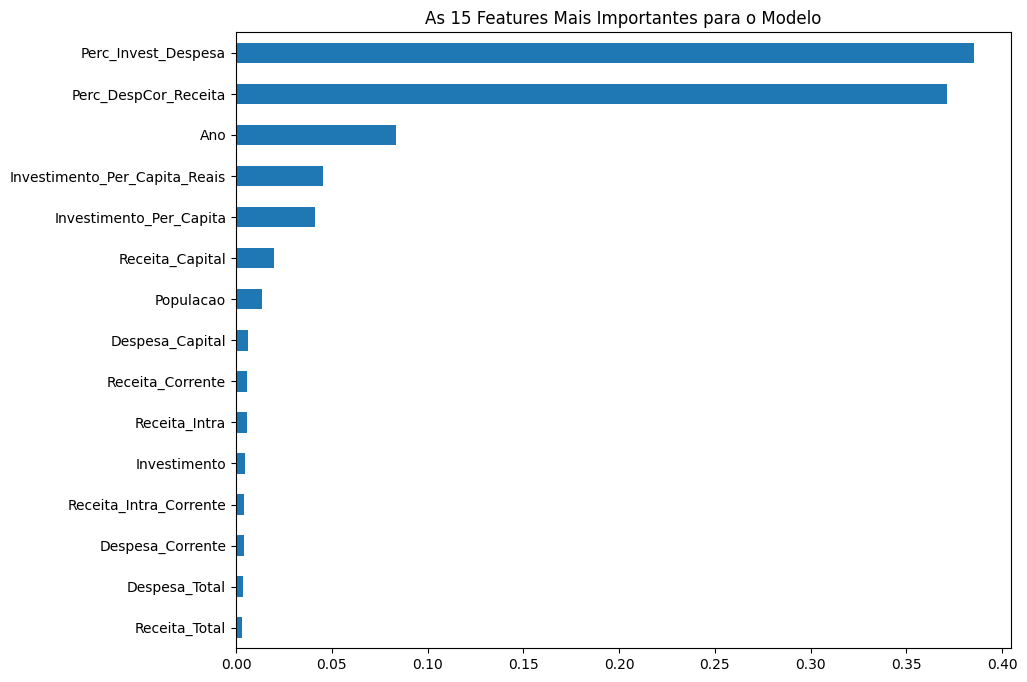

In [139]:
# Após treinar o best_rf
importancias = pd.Series(best_rf.feature_importances_, index=features)
plt.figure(figsize=(10, 8))
importancias.nlargest(15).sort_values().plot(kind='barh')
plt.title("As 15 Features Mais Importantes para o Modelo")
plt.show()

Análise: As variáveis mais dominantes `Perc_Invest_Despesa (Percentual de Investimento sobre a Despesa Total)` e `Perc_DespCor_Receita (Percentual de Despesa Corrente sobre a Receita Total)` validam o trabalho porque foram exatamente as métricas relativas criadas na engenharia de atributos. O modelo aprendeu e está confirmando que, para definir a saúde fiscal de um município, o mais importante não são os valores brutos, mas sim as proporções. Isso valida toda a lógica de criação do `target`.

##Conclusão

* O experimento demonstrou ganhos progressivos no desempenho dos modelos de classificação.
O **baseline** `(DummyClassifier)` obteve **acurácia de 42%** e `F1 Macro` de **0.15**, refletindo apenas a proporção da classe majoritária.
A `Regressão Logística` atingiu 65% de acurácia e `F1 Macro` de 0.42, indicando melhora em relação ao baseline, mas d**ificuldade em lidar com classes minoritárias.**

* Já a `Random Forest` simples obteve **86% de acurácia** e `F1 Macro` de **0.83**, mostrando superioridade clara. Por fim, a `Random Forest` otimizada via`RandomizedSearchCV` e `validação cruzada` alcançou **91% de acurácia** e `F1 Macro` de **0.88**, com bom equilíbrio entre as classes e robustez validada por `cross-validation`.
Isso evidencia que o modelo é capaz de aprender padrões relevantes a partir de variáveis financeiras e demográficas, mesmo após a exclusão de atributos derivados do target que poderiam causar vazamento de dados.

* O modelo final mostra que é possível prever níveis municipais com boa acurácia a partir de dados financeiros e demográficos, reforçando a aplicabilidade de métodos de machine learning na análise de finanças públicas.

## Resposta as Hipóteses do Problema

Após o desenvolvimento do trabalho segue as respostas percebidas ao final do MVP:

1.  O **`Investimento Público`** segue um padrão uniforme durante um determinado período de tempo ou apresenta variações?

🔹 Descobriu-se que o investimento público não é unfiforme ao longo do tempo. Apresenta períodos de crescimento e outros de queda.

2. Avaliar se a maior **`Receita Total`** ou maior **`Despesa Total`** está associada a maior capacidade de **`Investimento`** per capta.

🔹A avaliação mostrou que municípios que não se destacam nesses quesitos em valores brutos apareceram no top do gráfico em valores per capita.

3. Municípios com maiores gastos brutos são os que mais realizam investimentos em termos percentuais?

🔹Municípios que mais investem em termos brutos estão abaixo da média estadual de investimento em termos percentuais.

4. É possível `classificar` a `saúde financeira` de um município com base em `indicadores demográficos` e `indicadores financeiros` relacionados ao `Investimento Público`?

🔹O uso de Machine Learning mostrou-se plenamente viável para fazer esse processo. Depois de ajustes e uso de melhores algoritmos os resultados foram animadores.



## Limitações

Apesar dos avanços, o MVP apresenta algumas limitações:

* **Construção do target:** a variável resposta foi definida a partir de regras pré-estabelecidas. Isso limita a autonomia do modelo e pode restringir a descoberta de padrões alternativos.

* **Balanceamento de classes**: embora o uso de class_weight="balanced" tenha mitigado parcialmente o problema, ainda há desigualdade no desempenho entre classes (especialmente a classe VERDE).

* **Generalização:** os dados se restringem a um período e a um conjunto específico de municípios. Portanto, a extrapolação dos resultados para outros contextos deve ser feita com cautela.

* E**xplicabilidade:** a Random Forest fornece métricas de importância de variáveis, mas não garante interpretação causal direta.

## Sugestões Futuras

* Aplicar técnicas de balanceamento (ex.: SMOTE, undersampling).
* Testar outros algoritmos (Gradient Boosting, XGBoost, LightGBM).
* Revisitar a definição do target com base em indicadores externos.
* Expandir a base de dados para novos períodos e variáveis socioeconômicas.
* Utilizar métodos de interpretabilidade avançados (ex.: SHAP values).